In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
from numpy.random import normal
import pandas as pd
import glob
import datetime

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
path = "/scratch/gpfs/as111/results/"
date = '2023-12-22'
files = [[],[]]
files[0].extend(glob.glob(f"{path}{date}/*cond_gamma*scintillation_pulse_liq5.h5"))
files[1].extend(glob.glob(f"{path}{date}/*cond_backgrounds*scintillation_pulse_liq5.h5"))
print(len(files[0]), files[0])
print(len(files[1]), files[1])

20 ['/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run16_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run9_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run17_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run14_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run10_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run2_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run18_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run8_scintillation_pulse_l

In [4]:
# data folder
data = {}
date_time = {}
channels = np.arange(-1,8) # channel -1 contains total_pe and fprompt
volt = 96
cond = ['Co-60', 'Backgrounds']
for i, c in enumerate(cond):
    data[c] = {}
    for ch in channels:
        data[c][ch] = []
        for f in files[i]:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data[c][ch].append(df)
            df = None
        data[c][ch] = pd.concat(data[c][ch], ignore_index=True)
print(f'{len(data[cond[0]][-1]["total_pe"])} Co-60 events')
print(f'{len(data[cond[1]][-1]["total_pe"])} background events')
print('keys (ch=-1): ', list(data[cond[0]][-1].keys()))
print('keys (ch=0,1,2,3): ', list(data[cond[0]][0].keys()))

1007180 Co-60 events
99744 background events
keys (ch=-1):  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_top', 'nch_bot', 'total_pe', 'fprompt_0p10us', 'fprompt_0p20us', 'fprompt_0p30us', 'fprompt_0p40us', 'fprompt_0p50us']
keys (ch=0,1,2,3):  ['baseline_mean', 'baseline_rms', 'integral_0p10us', 'integral_0p20us', 'integral_0p30us', 'integral_0p40us', 'integral_0p50us', 'integral_5p00us', 'fired', 'amplitude', 'peakpos']


## Read calibration file

In [5]:
calib = pd.read_hdf('data/calibration_liq5_2023-12-13.h5', key=f'{volt}V')
calib

,channel,A1min,A1max,DiCT,DiCT_err,Qavg,Qavg_err,Qpeak,Qpeak_err,Qap,Qap_err,bsl_rms
0,0,169.50,543.25,0.046332,0.003478,1164.728477,1.304297,1131.491681,3.416132,0.028013,0.003161,2.0
1,1,153.25,517.25,0.049100,0.001656,1144.683208,1.851095,1113.892448,1.097667,0.026285,0.001851,2.0
2,2,153.25,517.25,0.049479,0.001834,1154.966355,1.610303,1122.321809,1.350212,0.027647,0.001801,2.0
3,3,150.00,510.75,0.043612,0.005856,1150.263808,2.583902,1117.967777,2.060560,0.027628,0.002859,2.0
4,4,114.25,413.25,0.032734,0.002590,916.492212,2.721177,904.480062,2.866587,0.012846,0.004256,2.0
5,5,130.50,429.50,0.058036,0.002614,912.401287,1.673212,898.871298,1.559696,0.014179,0.002414,2.0
6,6,140.25,436.00,0.033369,0.005075,904.286389,1.489399,892.146274,1.304836,0.013154,0.002158,2.0
7,7,133.75,442.50,0.031540,0.003544,915.056285,0.928691,902.121780,0.788094,0.013886,0.001315,2.0


In [6]:
convert_pe = calib['Qpeak']*(1+calib['Qap'])/(1-calib['DiCT'])
convert_pe

0    1219.699442
1    1202.199751
2    1213.388966
3    1201.244232
4     947.101399
5     967.782168
6     935.083935
7     944.435960
dtype: float64

## Baseline cut
Same baseline cut as calibration data (baseline std $<1.9$ ADC units). Cut fraction higher.

In [7]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for ch in channels:
        baseline[c][ch] = {}

In [8]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for ch in channels[1:]:
        baseline[c][ch]['rms_counts'], baseline[c][ch]['rms_bins'] = np.histogram(data[c][ch]['baseline_rms'], bins=nbins, range=(range_min, range_max))
        if ch==0:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==1:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==2:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==3:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==4:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==5:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==6:
            baseline[c][ch]['rms_threshold'] = 1.8
        elif ch==7:
            baseline[c][ch]['rms_threshold'] = 1.8

In [9]:
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
for c in cond:
    for ch in channels[1:]:
        baseline[c][ch]['mean_counts'], baseline[c][ch]['mean_bins'] = np.histogram(
            data[c][ch]['baseline_mean'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[c][ch]['mean_counts_cut'], baseline[c][ch]['mean_bins_cut'] = np.histogram(
            data[c][ch].loc[data[c][ch]['baseline_rms']<baseline[c][ch]['rms_threshold'],'baseline_mean'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

## Remove saturated events

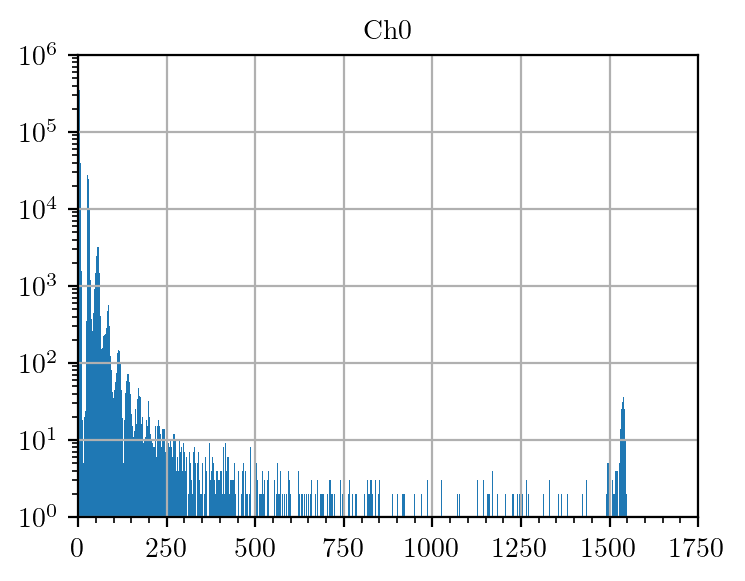

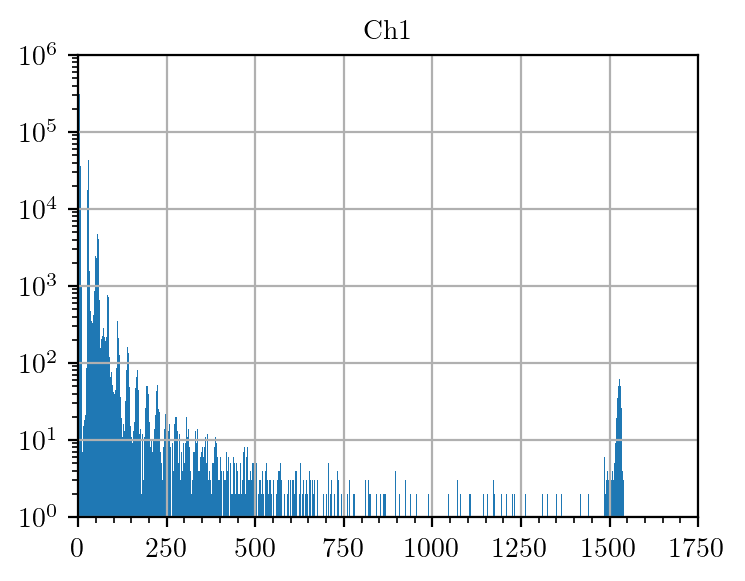

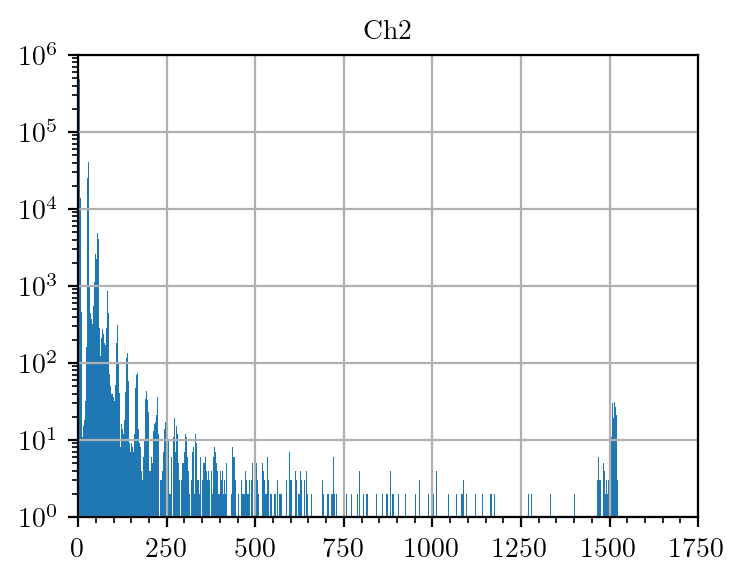

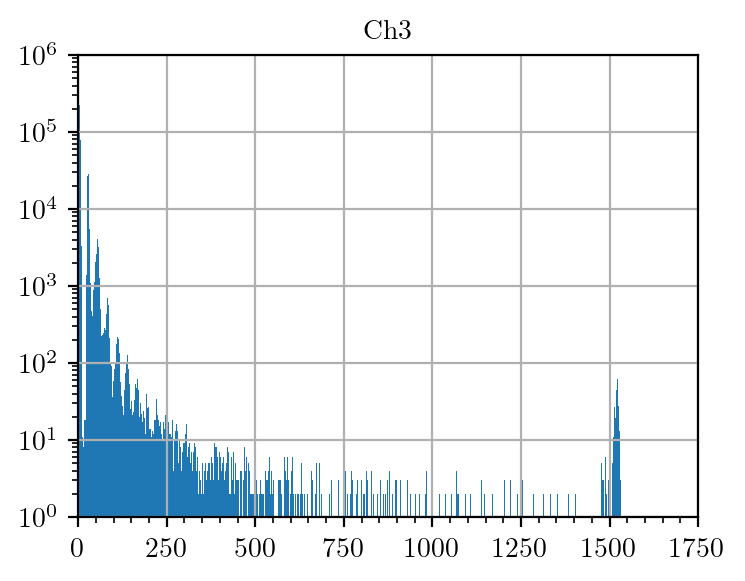

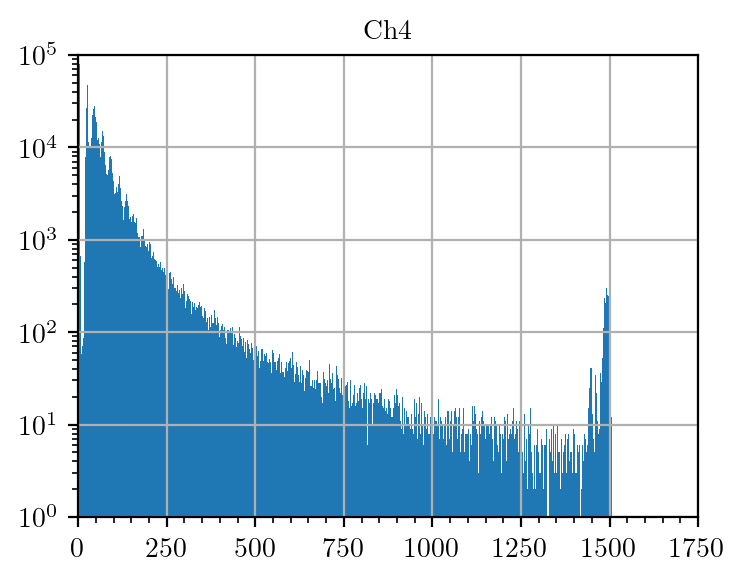

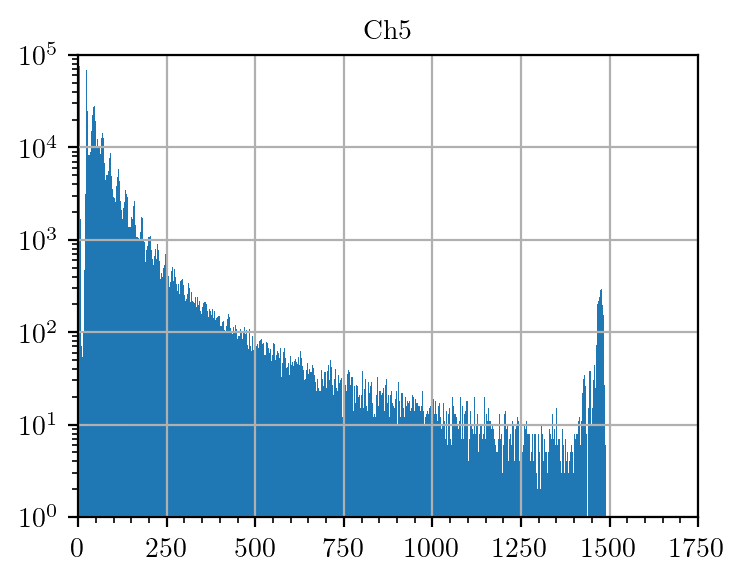

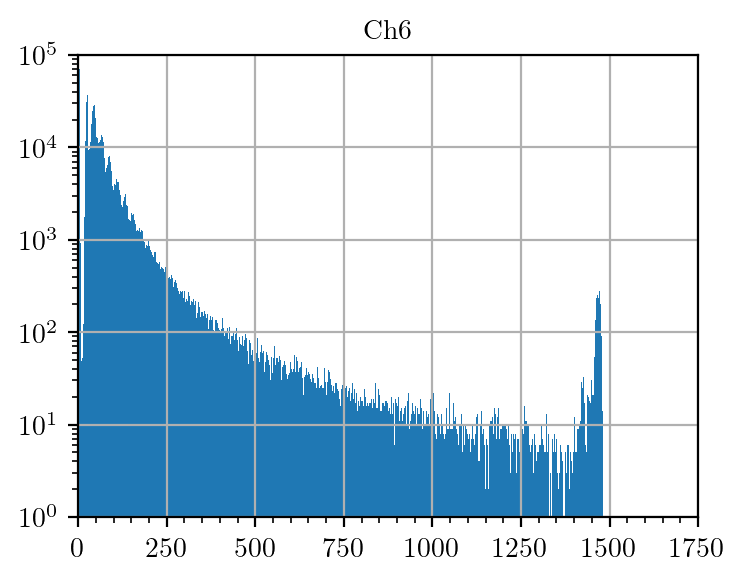

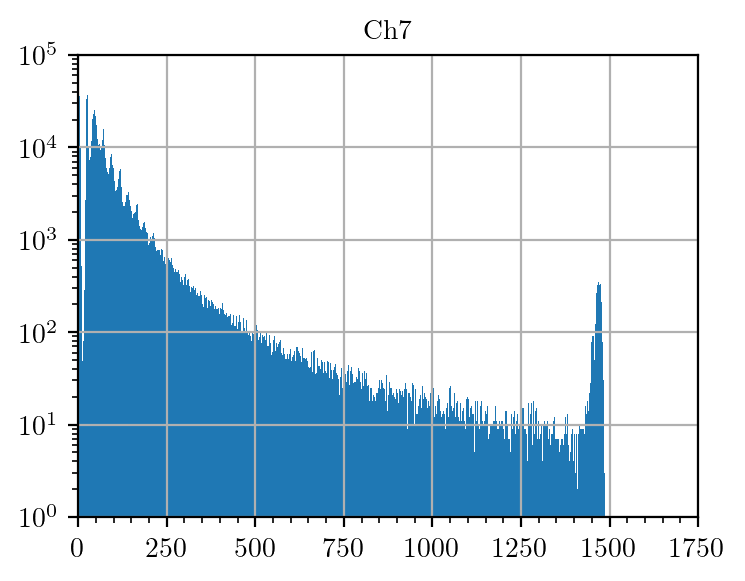

In [10]:
for ch in channels[1:]:
    plt.figure(ch)
    plt.hist(data[cond[0]][ch]['amplitude'],bins=np.linspace(0,1600,1000))
    plt.title(f'Ch{ch}')
    plt.yscale('log')
    plt.grid()
    plt.minorticks_on()

In [11]:
# Calculate cut fraction
data_aggr_nocut = {}
data_aggr_bslcut = {}
# Compute PEs from top and bottom SiPMs
pe_ch = {}
top_pe = {}
bot_pe = {}
for c in cond:
    pe_ch[c] = pd.concat([data[c][ch]['integral_5p00us'] for ch in range(8)],axis=1)
    pe_ch[c].columns = np.arange(8)
    pe_ch[c] = pe_ch[c]/convert_pe
    top_pe[c], bot_pe[c] = pe_ch[c].iloc[:,-4:].sum(axis=1), pe_ch[c].iloc[:,:4].sum(axis=1)
# combine total_pe, fprompt, and baseline rms for each channel into a single DF
    data_aggr_nocut[c] = np.vstack((
        data[c][-1]['total_pe'],
        top_pe[c],
        bot_pe[c],
        data[c][-1]['nch'],
        data[c][-1]['nch_top'],
        data[c][-1]['nch_bot'],
        data[c][-1]['fprompt_0p10us'],
        data[c][-1]['fprompt_0p20us'],
        data[c][-1]['fprompt_0p30us'],
        data[c][-1]['fprompt_0p40us'],
        data[c][-1]['fprompt_0p50us'],
        data[c][0]['baseline_rms'],
        data[c][1]['baseline_rms'],
        data[c][2]['baseline_rms'],
        data[c][3]['baseline_rms'],
        data[c][4]['baseline_rms'],
        data[c][5]['baseline_rms'],
        data[c][6]['baseline_rms'],
        data[c][7]['baseline_rms'],
        data[c][0]['amplitude'],
        data[c][1]['amplitude'],
        data[c][2]['amplitude'],
        data[c][3]['amplitude'],
        data[c][4]['amplitude'],
        data[c][5]['amplitude'],
        data[c][6]['amplitude'],
        data[c][7]['amplitude']
    )).T
    for ch in channels:
        data[c][ch] = None # clear memory
    data_aggr_nocut[c] = pd.DataFrame(
        data_aggr_nocut[c],
        columns=['total_pe','top_pe','bot_pe',
                 'nch','nch_top','nch_bot',
                 'fprompt_0p10us','fprompt_0p20us','fprompt_0p30us','fprompt_0p40us','fprompt_0p50us',
                 'baseline_rms0','baseline_rms1','baseline_rms2','baseline_rms3','baseline_rms4','baseline_rms5','baseline_rms6','baseline_rms7',
                 'amplitude0','amplitude1','amplitude2','amplitude3','amplitude4','amplitude5','amplitude6','amplitude7']
    )
    # apply baseline cut on all channels
    data_aggr_bslcut[c] = data_aggr_nocut[c].loc[ 
        (data_aggr_nocut[c]['baseline_rms0'] < baseline[c][0]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms1'] < baseline[c][1]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms2'] < baseline[c][2]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms3'] < baseline[c][3]['rms_threshold']) &
        (data_aggr_nocut[c]['baseline_rms4'] < baseline[c][4]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms5'] < baseline[c][5]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms6'] < baseline[c][6]['rms_threshold']) & 
        (data_aggr_nocut[c]['baseline_rms7'] < baseline[c][7]['rms_threshold']) &
        (data_aggr_nocut[c]['amplitude0'] < 1450) & 
        (data_aggr_nocut[c]['amplitude1'] < 1450) & 
        (data_aggr_nocut[c]['amplitude2'] < 1450) & 
        (data_aggr_nocut[c]['amplitude3'] < 1450) &
        (data_aggr_nocut[c]['amplitude4'] < 1400) & 
        (data_aggr_nocut[c]['amplitude5'] < 1400) & 
        (data_aggr_nocut[c]['amplitude6'] < 1400) & 
        (data_aggr_nocut[c]['amplitude7'] < 1400)
    ]
    cut_fraction = 1-data_aggr_bslcut[c].shape[0]/data_aggr_nocut[c].shape[0]
    data_aggr_nocut[c] = None # clear memory
    baseline[c][-1]['cut_fraction'] = cut_fraction
    print(f'{c} {volt}V cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data = None
data_aggr_nocut = None

Co-60 96V cut fraction = 7.78679%
Backgrounds 96V cut fraction = 10.12492%


In [12]:
# Print container keys
print('baseline keys: ', list(
    baseline[cond[0]][0].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'rms_threshold', 'mean_counts', 'mean_bins', 'mean_counts_cut', 'mean_bins_cut']


Text(0.07, 0.5, 'Count')

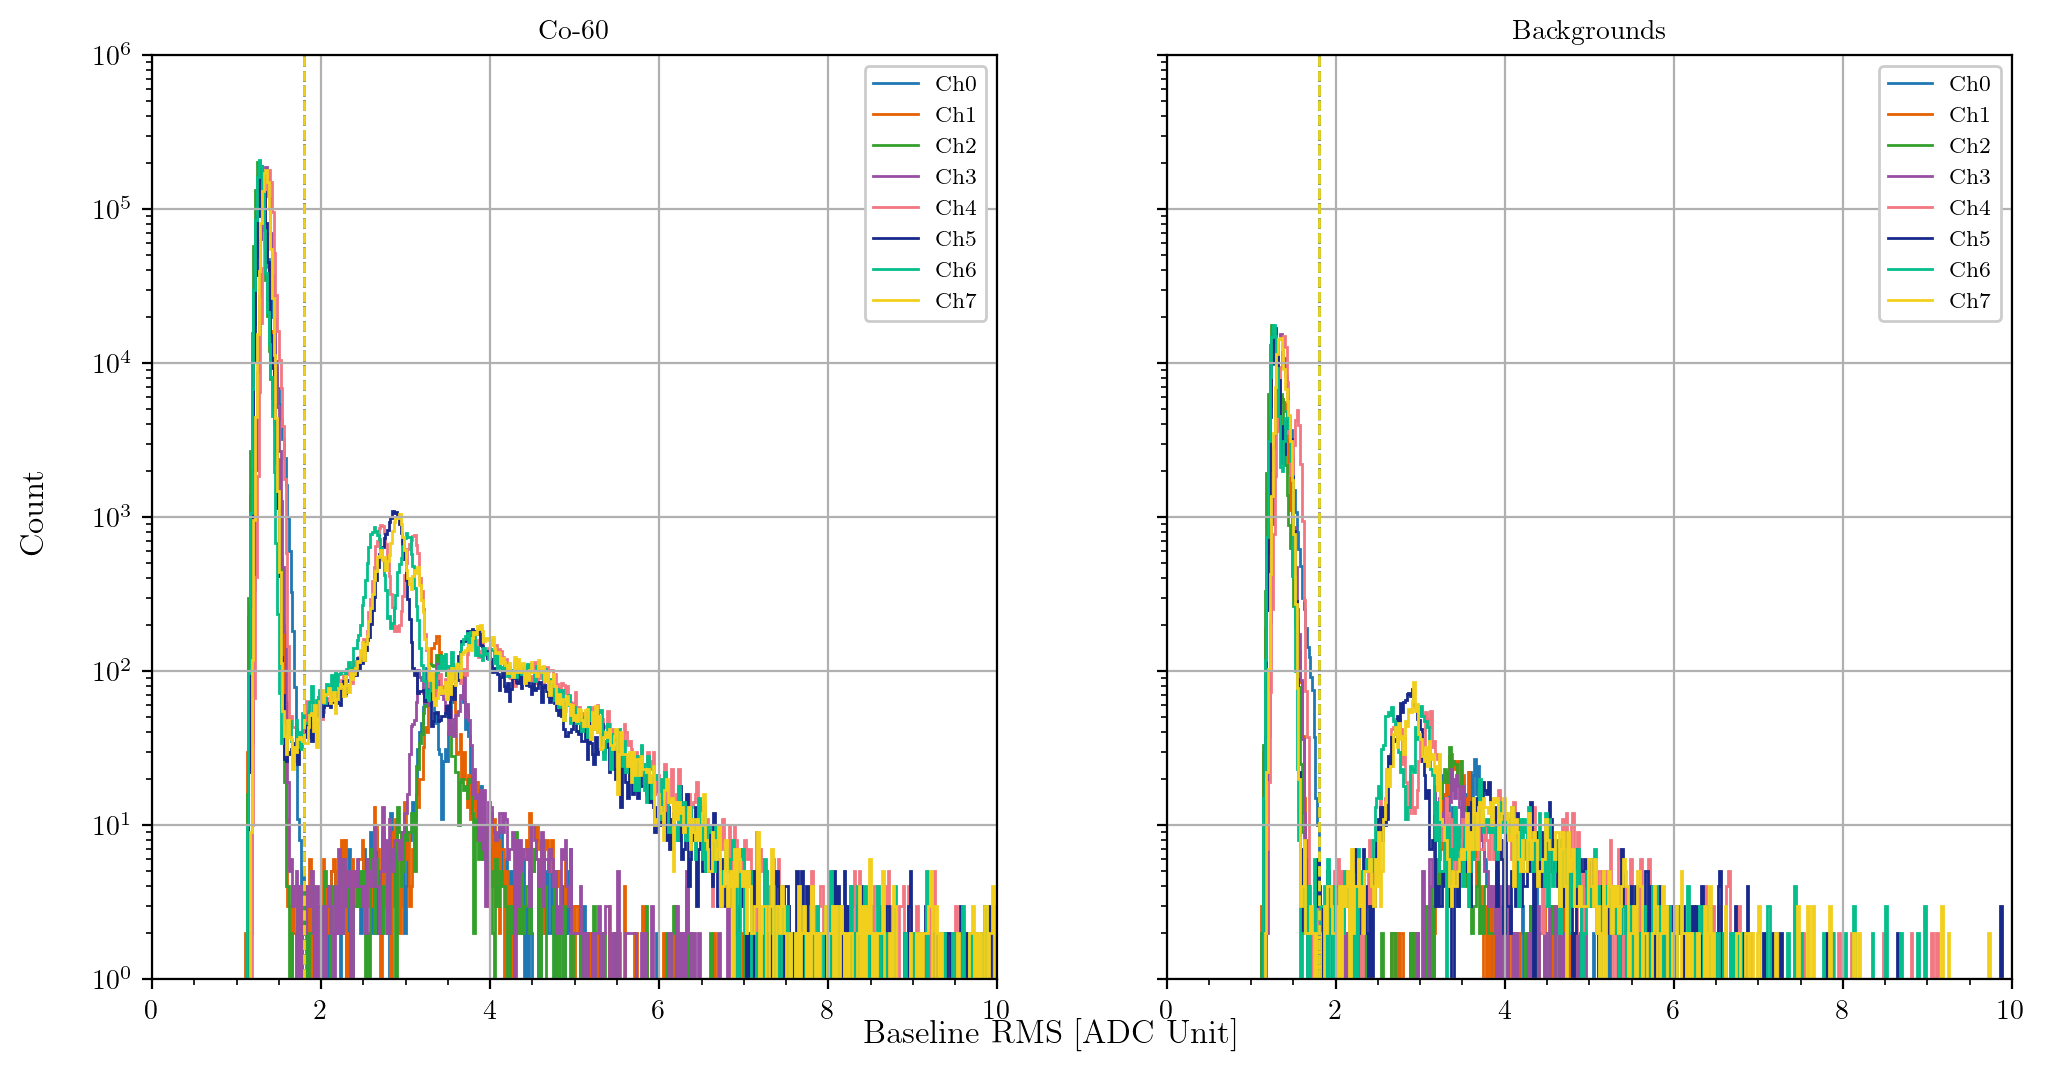

In [13]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['rms_counts'],
            baseline[c][ch]['rms_bins'],
            label=f'Ch{ch}', color=f'C{j}'
        )
        th = baseline[c][ch]['rms_threshold']
        axs[i].plot([th, th], [1, 1e6], f'C{j}--', linewidth=1)
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

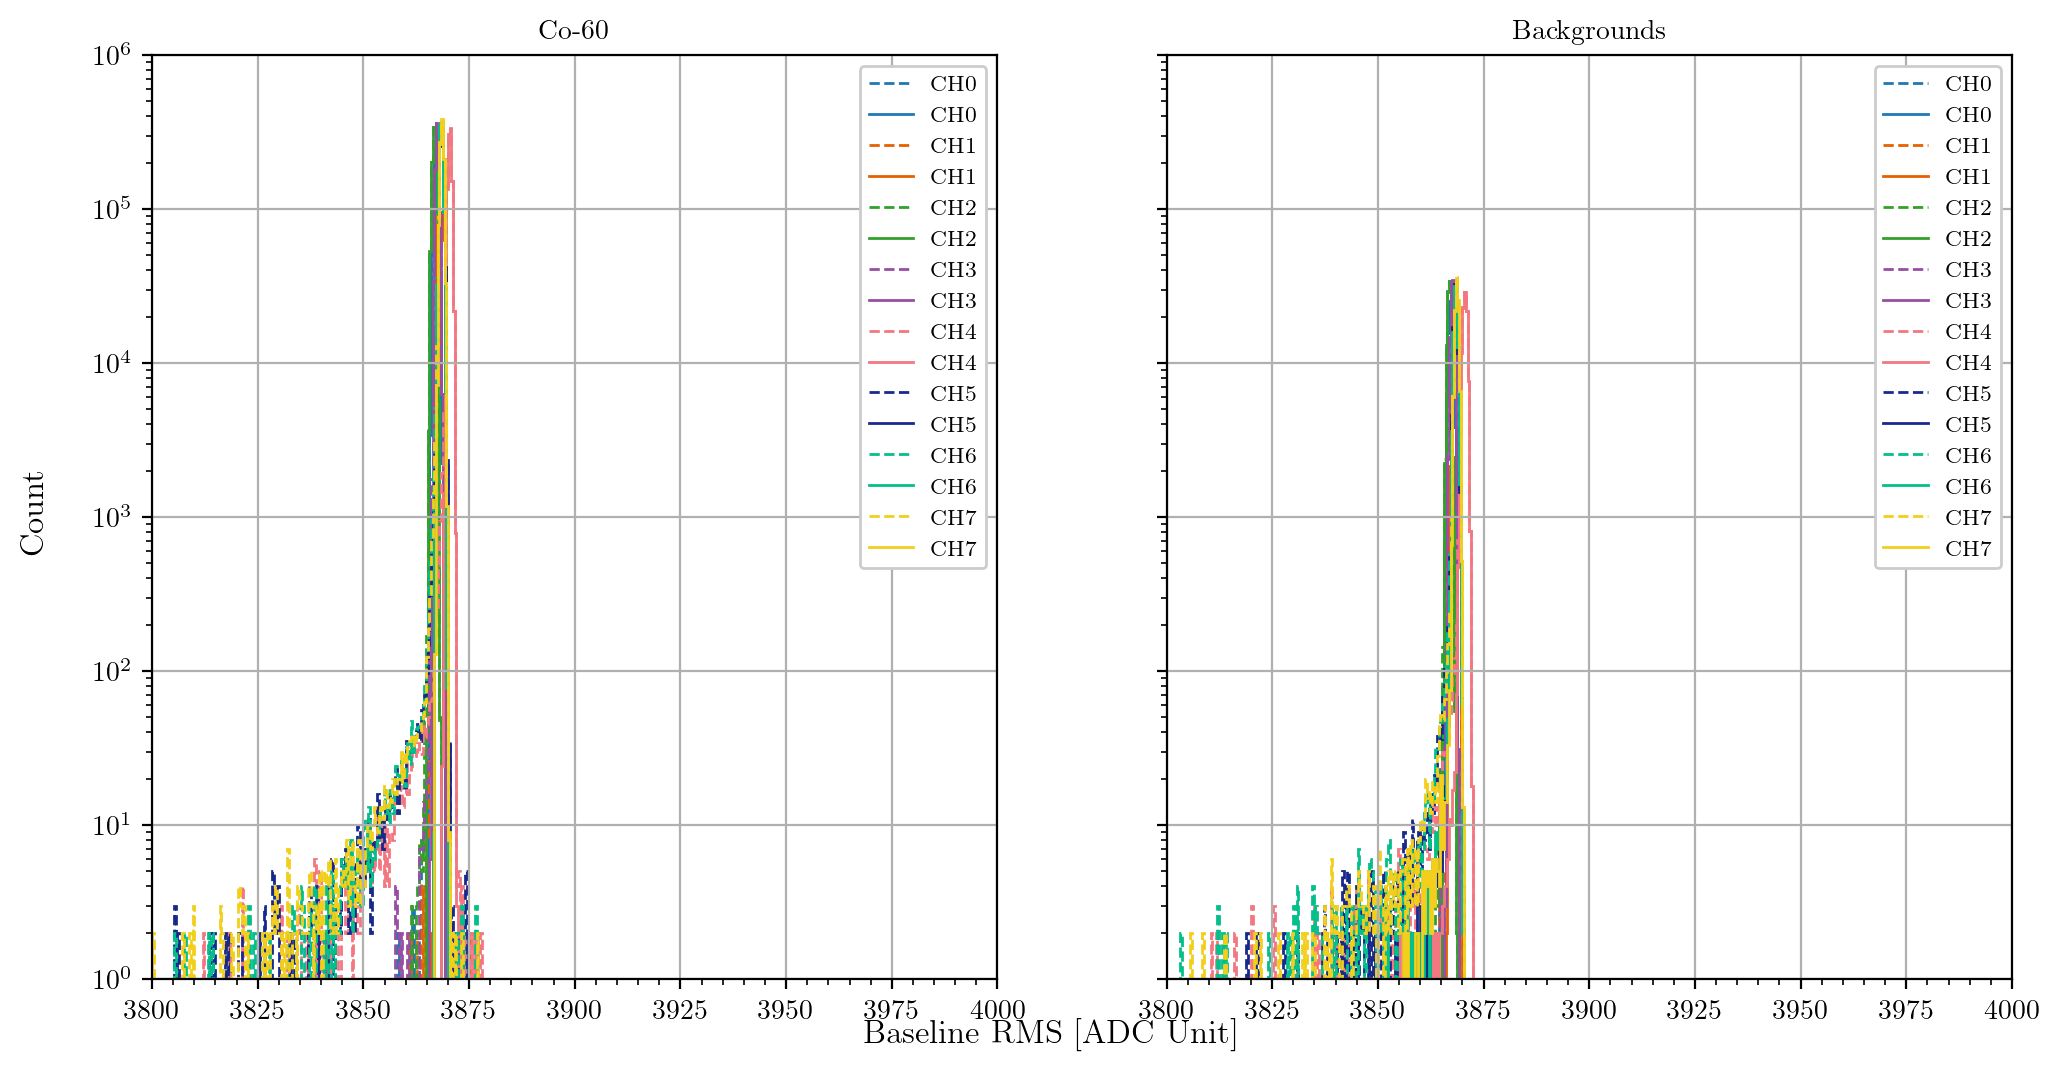

In [14]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['mean_counts'],
            baseline[c][ch]['mean_bins'],
            label=f'CH{ch}', color=f'C{j}', linestyle='--'
        )
        axs[i].stairs(
            baseline[c][ch]['mean_counts_cut'],
            baseline[c][ch]['mean_bins_cut'],
            label=f'CH{ch}', color=f'C{j}'
        )
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Plots for Co-60 ch0


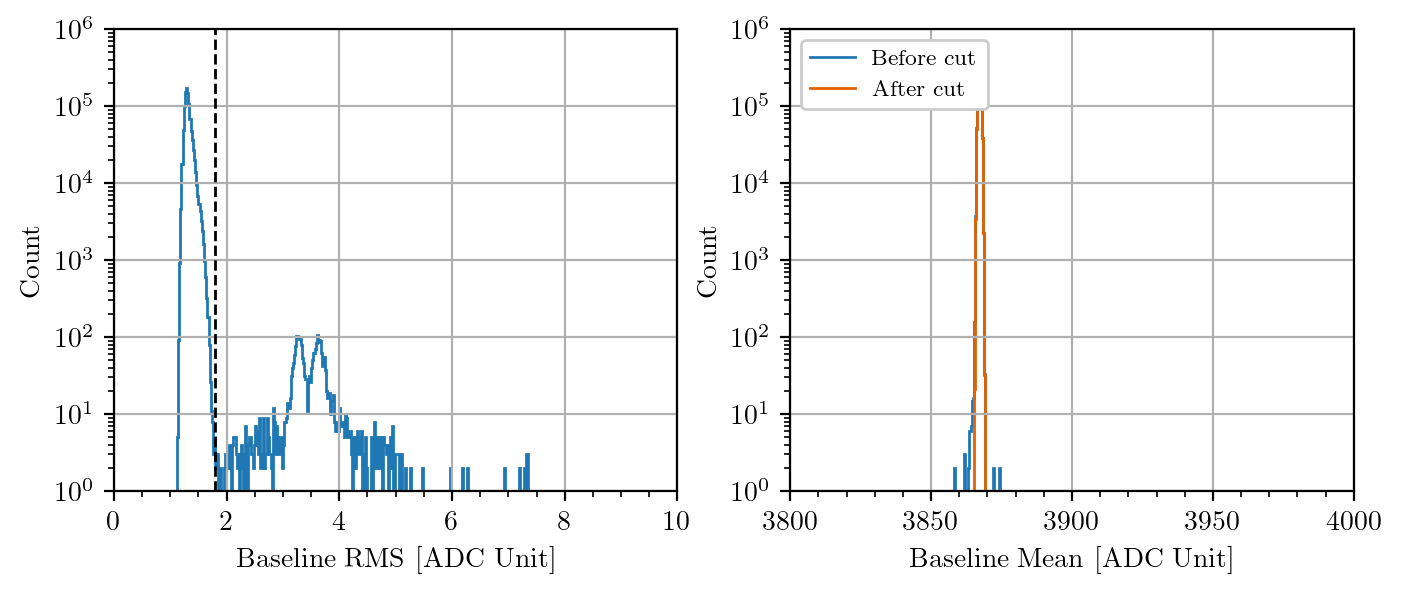

In [15]:
# Make plots for selected dataset
ch = 0
c = cond[0]
print(f'Plots for {c} ch{ch}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[c][ch]['rms_counts'],
              baseline[c][ch]['rms_bins'])
th = baseline[c][ch]['rms_threshold']
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[c][ch]['mean_counts'],
              baseline[c][ch]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[c][ch]['mean_counts_cut'],
              baseline[c][ch]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3800, 4000)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [16]:
# Initialize container
fprompt = {}
for c in cond:
    fprompt[c] = {}

In [17]:
# Produce fprompt 2D histograms
nbinsx = 600
range_minx = -10
range_maxx = 2000
nbinsy = 600
range_miny = -0.1
range_maxy = 1

for c in cond:
    fprompt[c]['fp_counts'], fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins'] = np.histogram2d(
        data_aggr_bslcut[c]['total_pe'], 
        data_aggr_bslcut[c]['fprompt_0p30us'], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['fp_counts'] = fprompt[c]['fp_counts'].T
    fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins'] = np.meshgrid(
        fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins']
    )
    fprompt[c]['fp_threshold'] = 0.1

Text(0.07, 0.5, '$F_{\\rm prompt}$')

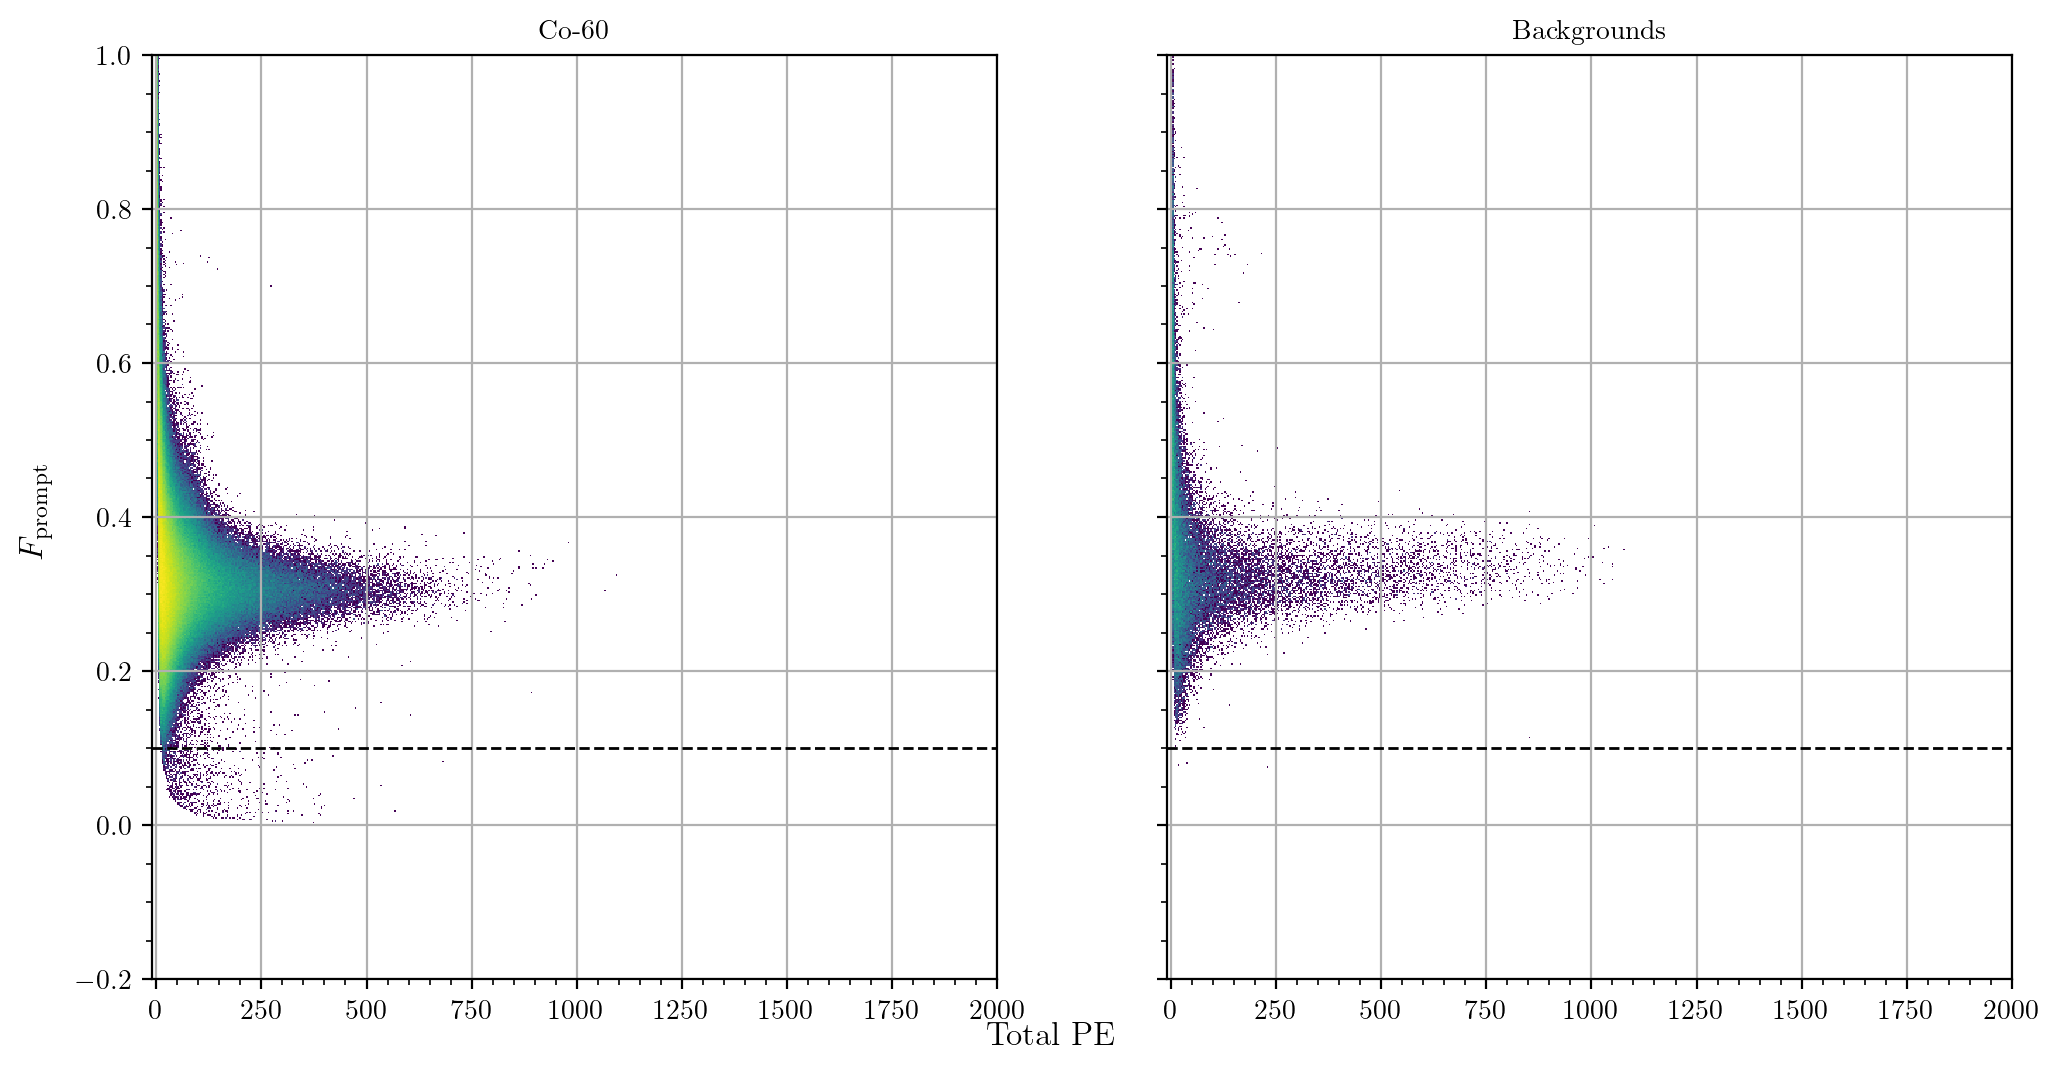

In [18]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        fprompt[c]['fp_xbins'],
        fprompt[c]['fp_ybins'],
        np.log10(fprompt[c]['fp_counts'])
    )
    th = fprompt[c]['fp_threshold']
    axs[i].plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
    axs[i].set_xlim(-10, range_maxx)
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Total PE', y=0.05)
fig.supylabel(r'$F_{\rm prompt}$', x=0.07)

In [19]:
# Calculate cut fraction: fprompt>0.1
data_aggr_allcuts = {}
for c in cond:  
    data_aggr_allcuts[c] = data_aggr_bslcut[c].loc[ 
        data_aggr_bslcut[c]['fprompt_0p30us']>fprompt[c]['fp_threshold'] 
    ]
    cut_fraction = 1-data_aggr_allcuts[c].shape[0]/data_aggr_bslcut[c].shape[0]
    fprompt[c]['cut_fraction'] = cut_fraction
    print(f'{c} cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data_aggr_bslcut = None

Co-60 cut fraction = 0.15085%
Backgrounds cut fraction = 0.16956%


In [20]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[cond[0]].keys()))
print('data_aggr_allcuts keys: ', list(
    data_aggr_allcuts[cond[0]].keys()))

fprompt keys:  ['fp_counts', 'fp_xbins', 'fp_ybins', 'fp_threshold', 'cut_fraction']
data_aggr_allcuts keys:  ['total_pe', 'top_pe', 'bot_pe', 'nch', 'nch_top', 'nch_bot', 'fprompt_0p10us', 'fprompt_0p20us', 'fprompt_0p30us', 'fprompt_0p40us', 'fprompt_0p50us', 'baseline_rms0', 'baseline_rms1', 'baseline_rms2', 'baseline_rms3', 'baseline_rms4', 'baseline_rms5', 'baseline_rms6', 'baseline_rms7', 'amplitude0', 'amplitude1', 'amplitude2', 'amplitude3', 'amplitude4', 'amplitude5', 'amplitude6', 'amplitude7']


## Top-Bottom 2D Distribution

In [21]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 300

top_bot_pe = {}
for c in cond:
    top_bot_pe[c] = {}
    top_bot_pe[c]['counts'], top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.histogram2d(
        data_aggr_allcuts[c]['top_pe'], 
        data_aggr_allcuts[c]['bot_pe'], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    top_bot_pe[c]['counts'] = top_bot_pe[c]['counts'].T
    top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.meshgrid(
        top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins']
    )

Backgrounds to be scaled by 0.13761467889908258


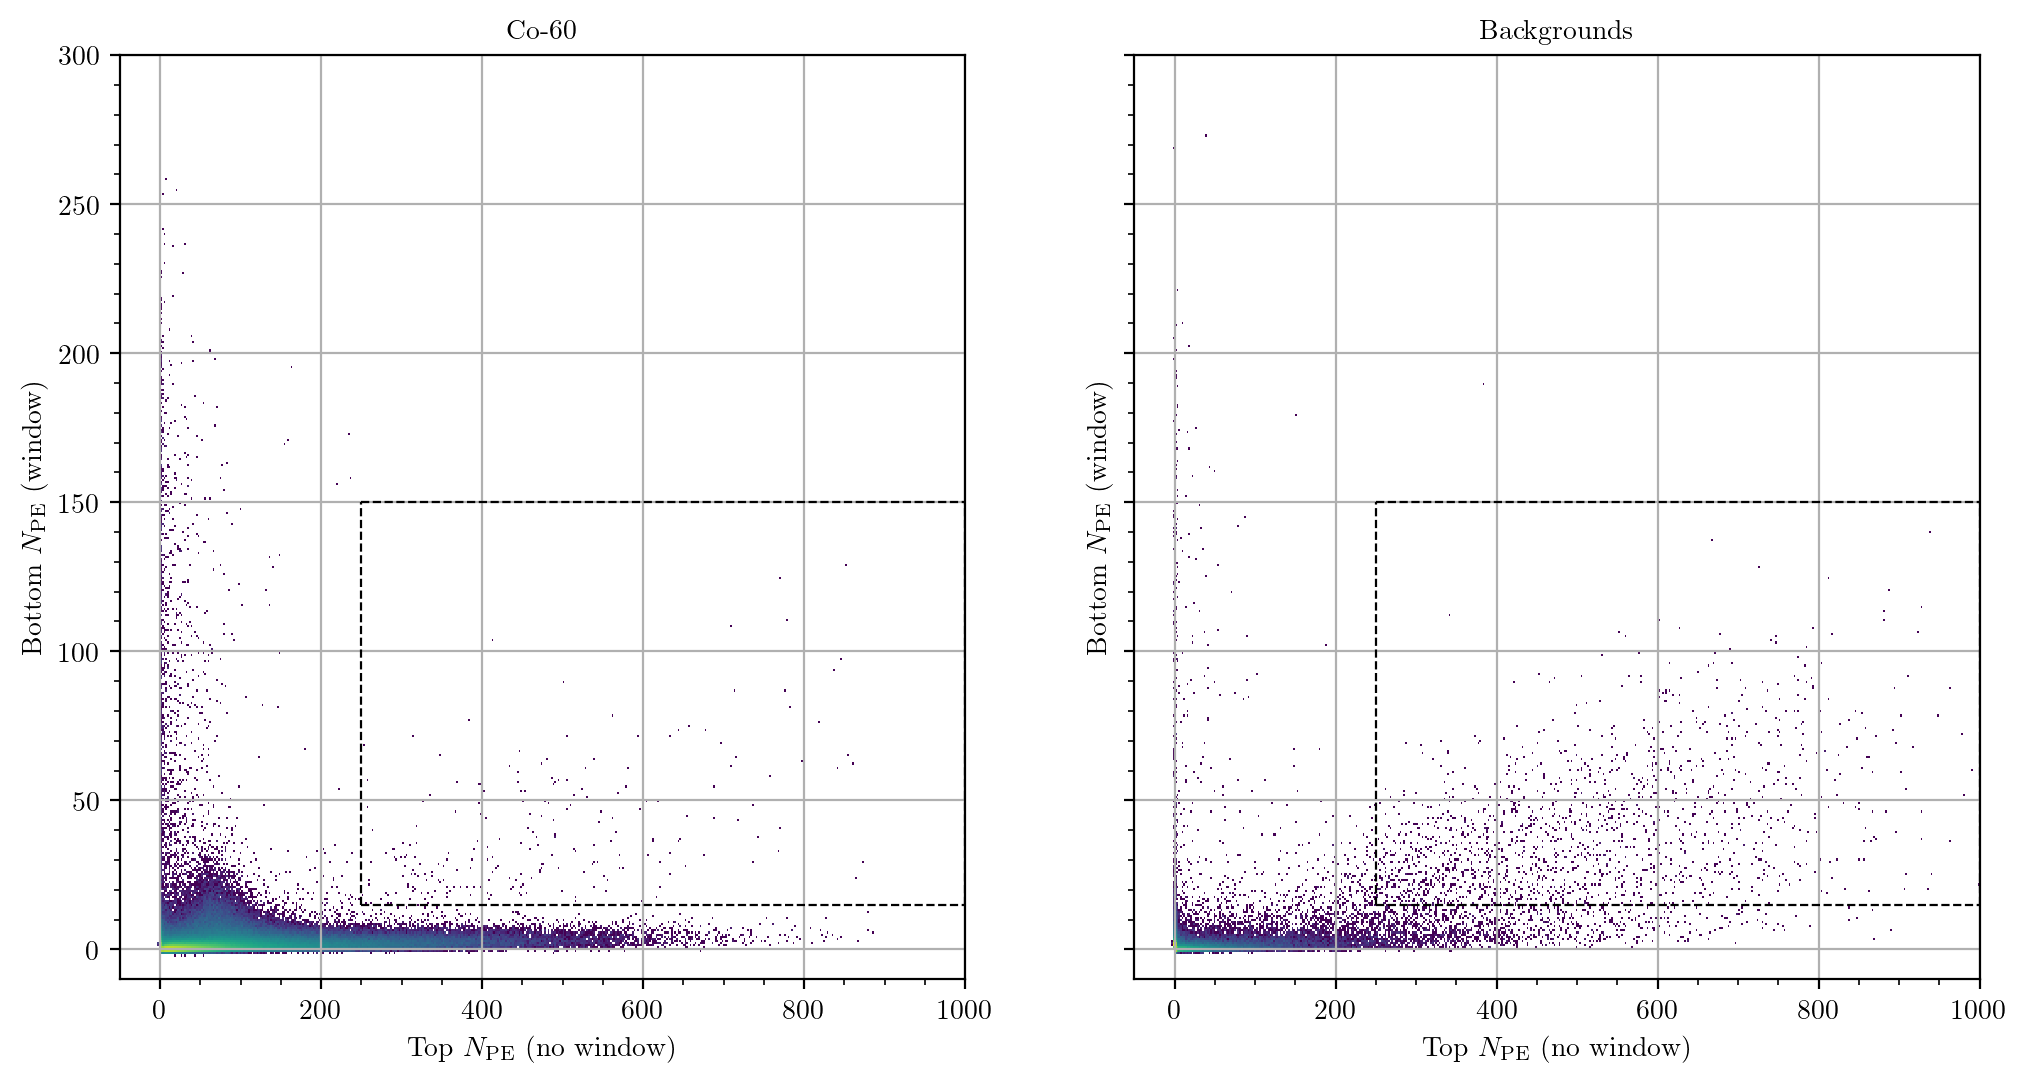

In [22]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
x1, y1, x2, y2 = 250, 15, 1000, 150
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        top_bot_pe[c]['xbins'],
        top_bot_pe[c]['ybins'],
        np.log10(top_bot_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 1000)
    axs[i].set_ylim(-10, 300)
    axs[i].set_xlabel(r'Top $N_{\rm PE}$ (no window)')
    axs[i].set_ylabel(r'Bottom $N_{\rm PE}$ (window)')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)

mask_x, mask_y = (top_bot_pe[c]['xbins'][0,1:]<x2)&(top_bot_pe[c]['xbins'][0,1:]>x1), (top_bot_pe[c]['ybins'][1:,0]<y2)&(top_bot_pe[c]['ybins'][1:,0]>y1)
bkg_scale = np.sum(top_bot_pe[cond[0]]['counts'][mask_y][:,mask_x])/np.sum(top_bot_pe[cond[1]]['counts'][mask_y][:,mask_x])
print(f'Backgrounds to be scaled by {bkg_scale}')

## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

In [25]:
hist_grouped_top = data_aggr_allcuts[cond[0]].groupby(['nch_top','nch_bot']).apply(lambda x: np.histogram(x['top_pe'], bins=np.linspace(-50,1000,1000)))
print(hist_grouped_top)

nch_top  nch_bot
0.0      1.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         2.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         3.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         4.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1.0      0.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         1.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         2.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         3.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         4.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2.0      0.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         1.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         2.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         3.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
         4.0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3.0

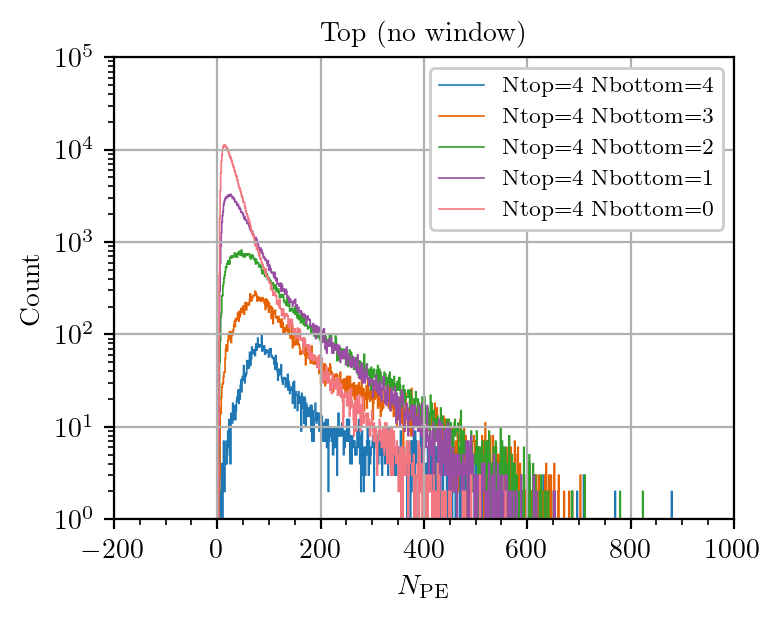

In [35]:
plt.stairs(hist_grouped_top.loc[(4,4)][0], hist_grouped_top.loc[(4,4)][1], label='Ntop=4 Nbottom=4', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,3)][0], hist_grouped_top.loc[(4,3)][1], label='Ntop=4 Nbottom=3', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,2)][0], hist_grouped_top.loc[(4,2)][1], label='Ntop=4 Nbottom=2', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,1)][0], hist_grouped_top.loc[(4,1)][1], label='Ntop=4 Nbottom=1', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,0)][0], hist_grouped_top.loc[(4,0)][1], label='Ntop=4 Nbottom=0', linewidth=0.6)
plt.minorticks_on()
plt.grid()
plt.yscale('log')
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel('Count')
plt.title('Top (no window)')
plt.legend(loc='upper right')

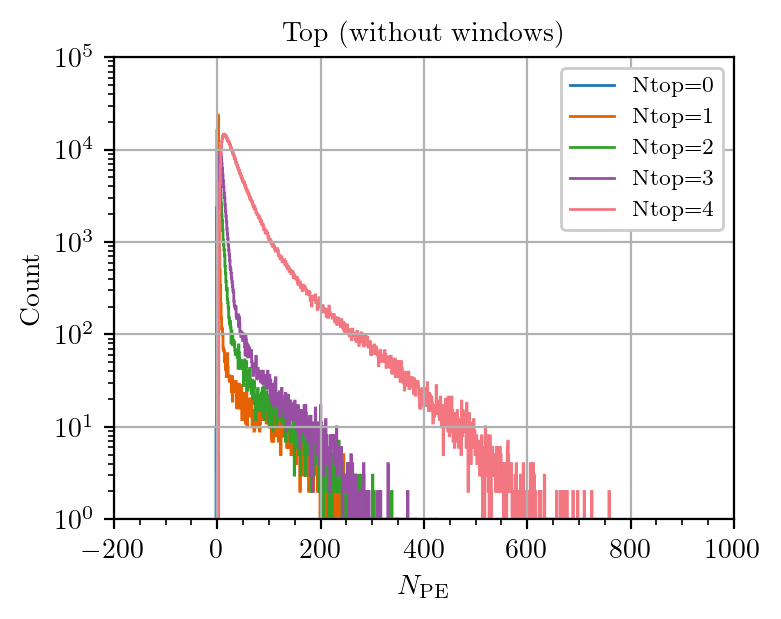

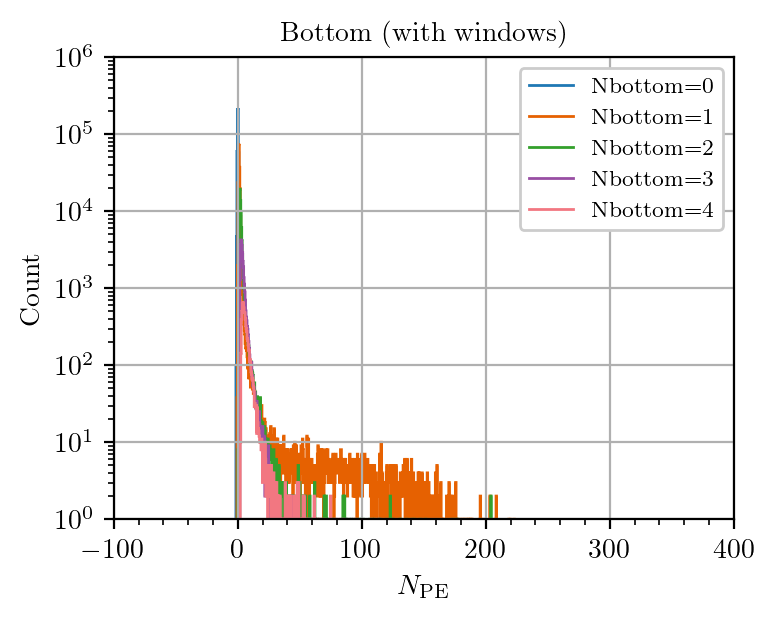

In [170]:
hist_grouped_top = data_aggr_allcuts[cond[0]].groupby('nch_top').apply(lambda x: np.histogram(x['top_pe'], bins=np.linspace(-50,1000,1000)))
hist_grouped_bot = data_aggr_allcuts[cond[0]].groupby('nch_bot').apply(lambda x: np.histogram(x['bot_pe'], bins=np.linspace(-50,400,1000)))
hist_grouped_top_bkg = data_aggr_allcuts[cond[1]].groupby('nch_top').apply(lambda x: np.histogram(x['top_pe'], bins=np.linspace(-50,1000,1000)))
hist_grouped_bot_bkg = data_aggr_allcuts[cond[1]].groupby('nch_bot').apply(lambda x: np.histogram(x['bot_pe'], bins=np.linspace(-50,400,1000)))
for i in hist_grouped_top.index:
    plt.figure(0)
    plt.stairs(hist_grouped_top.loc[i][0], hist_grouped_top.loc[i][1]-hist_grouped_top_bkg.loc[i][1]*bkg_scale, label=f'Ntop={i:.0f}')
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.legend(loc='upper right')
    plt.title('Top (without windows)')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Count')
for i in hist_grouped_bot.index:
    plt.figure(1)
    plt.stairs(hist_grouped_bot.loc[i][0], hist_grouped_bot.loc[i][1]-hist_grouped_bot_bkg.loc[i][1]*bkg_scale, label=f'Nbottom={i:.0f}')
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.legend(loc='upper right')
    plt.title('Bottom (with windows)')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Count')

In [171]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [172]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data_aggr_allcuts[c]['top_pe'] if w=='no' else data_aggr_allcuts[c]['bot_pe'], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])
        if c=='Backgrounds':
            spectra[c][w]['counts'] = spectra[c][w]['counts']*bkg_scale
            spectra[c][w]['errs'] = spectra[c][w]['errs']*bkg_scale

# Backgrounds and Cs-137 Data

Text(0.07, 0.5, 'Count')

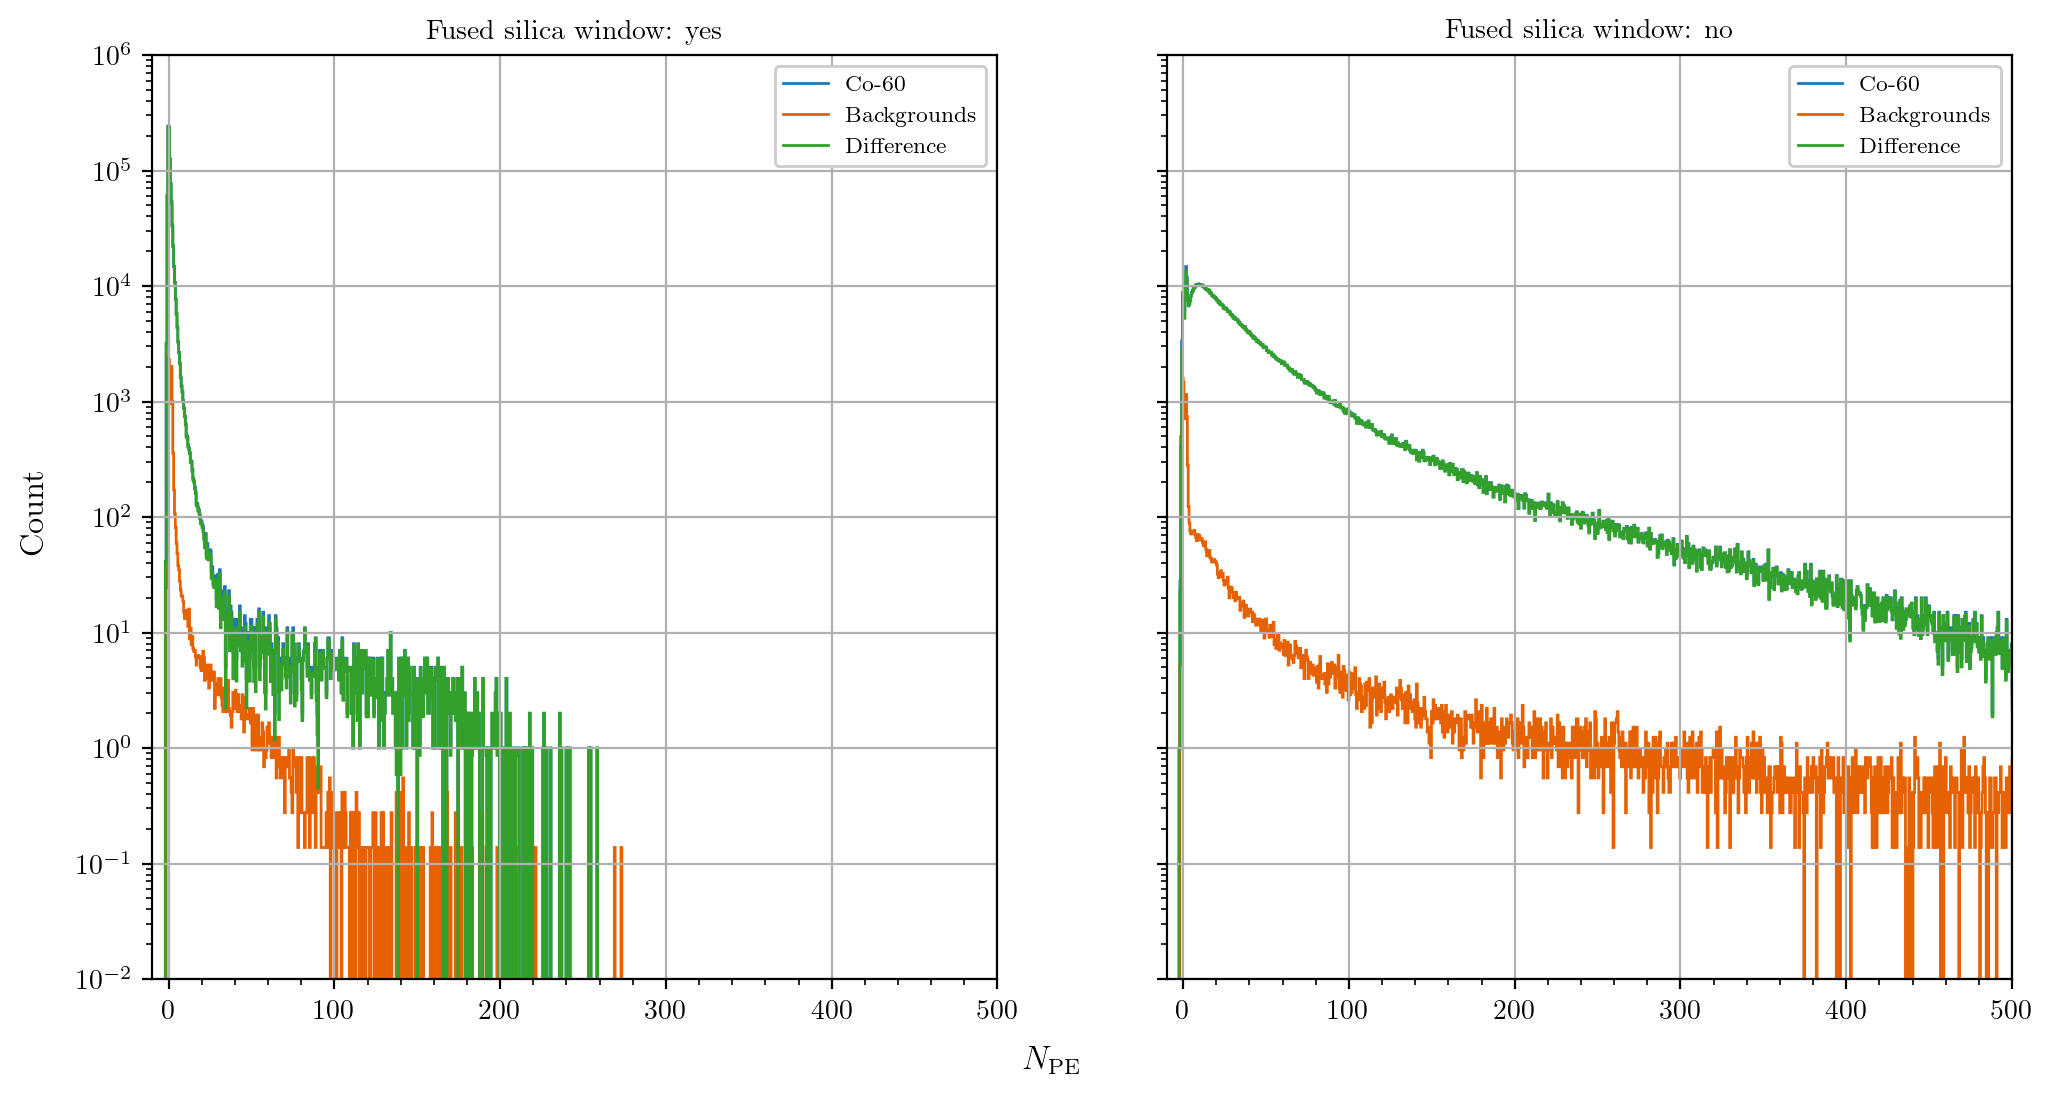

In [173]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 6)
for j, w in enumerate(window):
    for i, c in enumerate(cond):
        axs[j].stairs(
            spectra[c][w]['counts'],
            spectra[c][w]['bins'],
            label=f'{c}', color=f'C{i}'
        )
    axs[j].stairs(spectra['Co-60'][w]['counts']-spectra['Backgrounds'][w]['counts'], 
                  spectra['Co-60'][w]['bins'], label='Difference', color='C2')
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-2, 1e6)
    axs[j].set_xlim(-10, 500)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

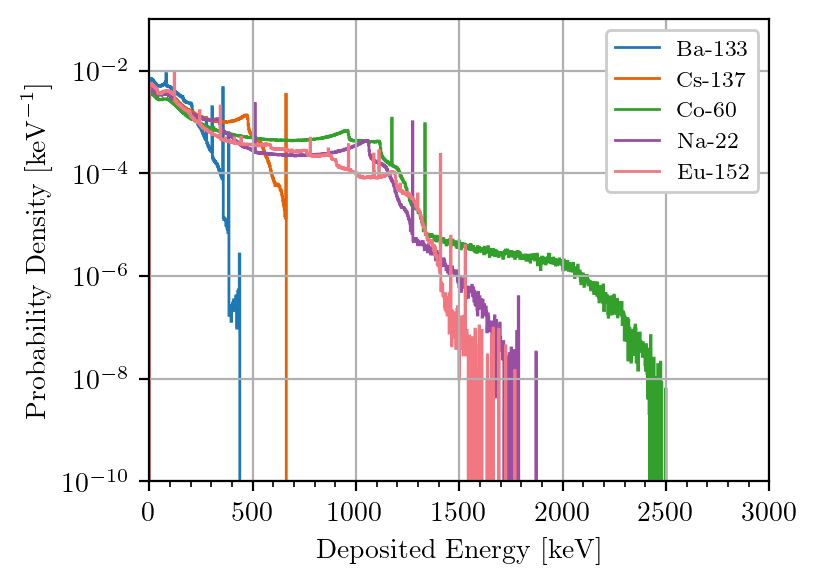

In [2]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root','spectrum_cs137_ene.root','spectrum_co60_ene.root','spectrum_na22_ene.root','spectrum_eu152_ene.root']
gammas = ['Ba-133','Cs-137','Co-60','Na-22','Eu-152']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-10,1e-1)
plt.xlim(0,3000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

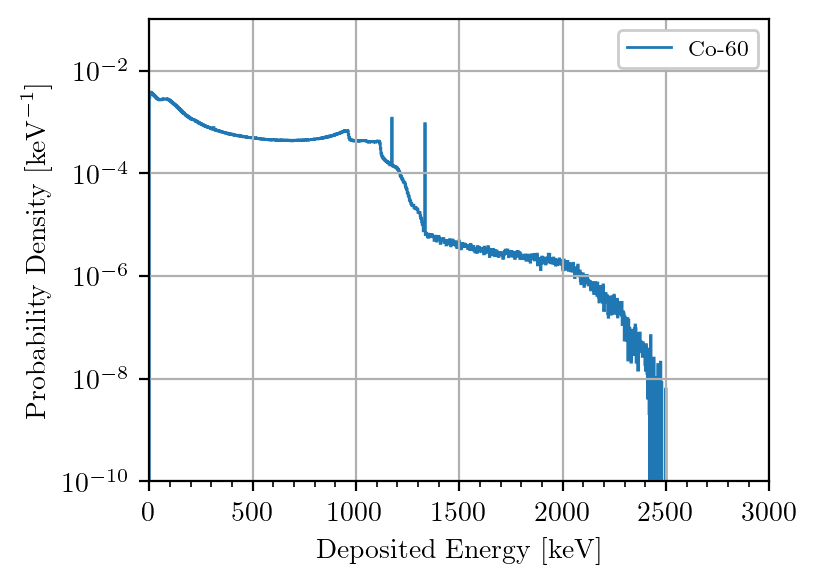

In [3]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_co60_ene.root']
gammas = ['Co-60']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-10,1e-1)
plt.xlim(0,3000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [4]:
import scipy.integrate as intg 
from scipy.stats import norm
import math

class Spectrum():
    def __init__(self, dict, root_file_path="data/gamma/spectrum_cs137_ene.root", pe_max=1500, pe_width=5):
        self.pe_max = pe_max
        self.pe_width = pe_width
        self.root_file_path = root_file_path
        self.bins_ene =[]
        self.rates_ene = []
        self.dict = dict
        self.ly = 0
        self.alpha = 0
        self.read_energy_spectrum()
    
    def read_energy_spectrum(self):
        self.root_file = ROOT.TFile.Open(self.root_file_path, "read")
        root_hist = self.root_file.Get("hEne")
        for i in range(1,root_hist.GetNbinsX()+1):
            self.bins_ene.append(root_hist.GetBinLowEdge(i))
            self.rates_ene.append(root_hist.GetBinContent(i))
        self.bins_ene.append(self.bins_ene[-1]+root_hist.GetBinWidth(1))
        self.bins_ene = np.array(self.bins_ene)
        self.rates_ene = np.array(self.rates_ene)
        self.rates_ene /= np.sum(self.rates_ene) # normalize total count to 1

    def response_matrix(self, ene, pe, ly):
        return norm.pdf(pe, loc=ly*ene, scale=np.sqrt(ly*ene*(1+self.dict)))

    def get_pe_spectrum(self, ly, alpha):
        self.ly = ly
        self.alpha = alpha
        # self.bins_pe = self.bins_ene*ly
        self.bins_pe = np.arange(0,self.pe_max, self.pe_width)
        self.rates_pe = np.zeros(self.bins_pe.shape[0]-1)
        bincen_ene = (self.bins_ene[1:] + self.bins_ene[:-1])/2
        bincen_pe = (self.bins_pe[1:] + self.bins_pe[:-1])/2
        bincen_ly = np.linspace(max(ly*(1-3*alpha),0), ly*(1+5*alpha), 100)
        ene_mesh, pe_mesh, ly_mesh = np.meshgrid( bincen_ene, bincen_pe, bincen_ly)
        s_ly = norm.pdf(bincen_ly,loc=ly, scale=ly*alpha)
        self.rates_pe = np.dot(np.dot(self.response_matrix(ene_mesh, pe_mesh, ly_mesh),s_ly),self.rates_ene)
        self.rates_pe *= (bincen_ly[1]-bincen_ly[0])
        
    def pe_spectrum(self, pe, ly, alpha, n):
        if not math.isclose(ly, self.ly) or not math.isclose(alpha, self.alpha):
            self.get_pe_spectrum(ly, alpha)
        pe_id = (np.clip(pe/(self.bins_pe[1]-self.bins_pe[0]),0, self.bins_pe.shape[0]-2)).astype(int)
        return n*self.rates_pe[pe_id]

## Read DiCT probability from h5 file

In [5]:
p_dict = {}
syserr2 = {}
volt = 96
calib_df = pd.read_hdf('data/calibration_liq5_2023-12-13.h5',key=f'/{volt}V')
p_dict[volt] = np.mean(calib_df['DiCT'])
syserr2[volt] = np.mean((calib_df['Qpeak_err']/calib_df['Qpeak'])**2 + (calib_df['DiCT_err']/(1-calib_df['DiCT']))**2)
print('DiCT probability:')
print(p_dict)
print('Systematics from calibration:')
print(syserr2)

DiCT probability:
{96: 0.0430253288674188}
Systematics from calibration:
{96: 1.8031243222521968e-05}


In [6]:
volt = 96
s = Spectrum(p_dict[volt], pe_max=3000, pe_width=3, root_file_path="data/gamma/spectrum_co60_ene.root")
alphas = [0.1]
lys = [1.0]
pe_arr = np.arange(0,1500,1)
styles = ['solid', 'dashed', 'dotted']
plt.figure(figsize=(4,3))
for i,a_ in enumerate(alphas): 
    for j,l_ in enumerate(lys):
        s.get_pe_spectrum(l_, a_)
        pe_spectrum = s.pe_spectrum(pe_arr, l_, a_, 1.0)
        plt.plot(pe_arr, pe_spectrum,label=r'${}$PE/keV, $\alpha$={}'.format(l_,a_),color=f'C{j}',linestyle=styles[i])
plt.yscale('log')
plt.ylim(1e-9,1e-1)
plt.xlim(0,3000)
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper right',ncol=3,prop={'size': 5})
plt.ylabel('Probability Density')
plt.xlabel(r'$N_{\rm PE}$')

: 

: 

# Compare with MC spectra + response model

Text(0.07, 0.5, 'Probability Density per PE')

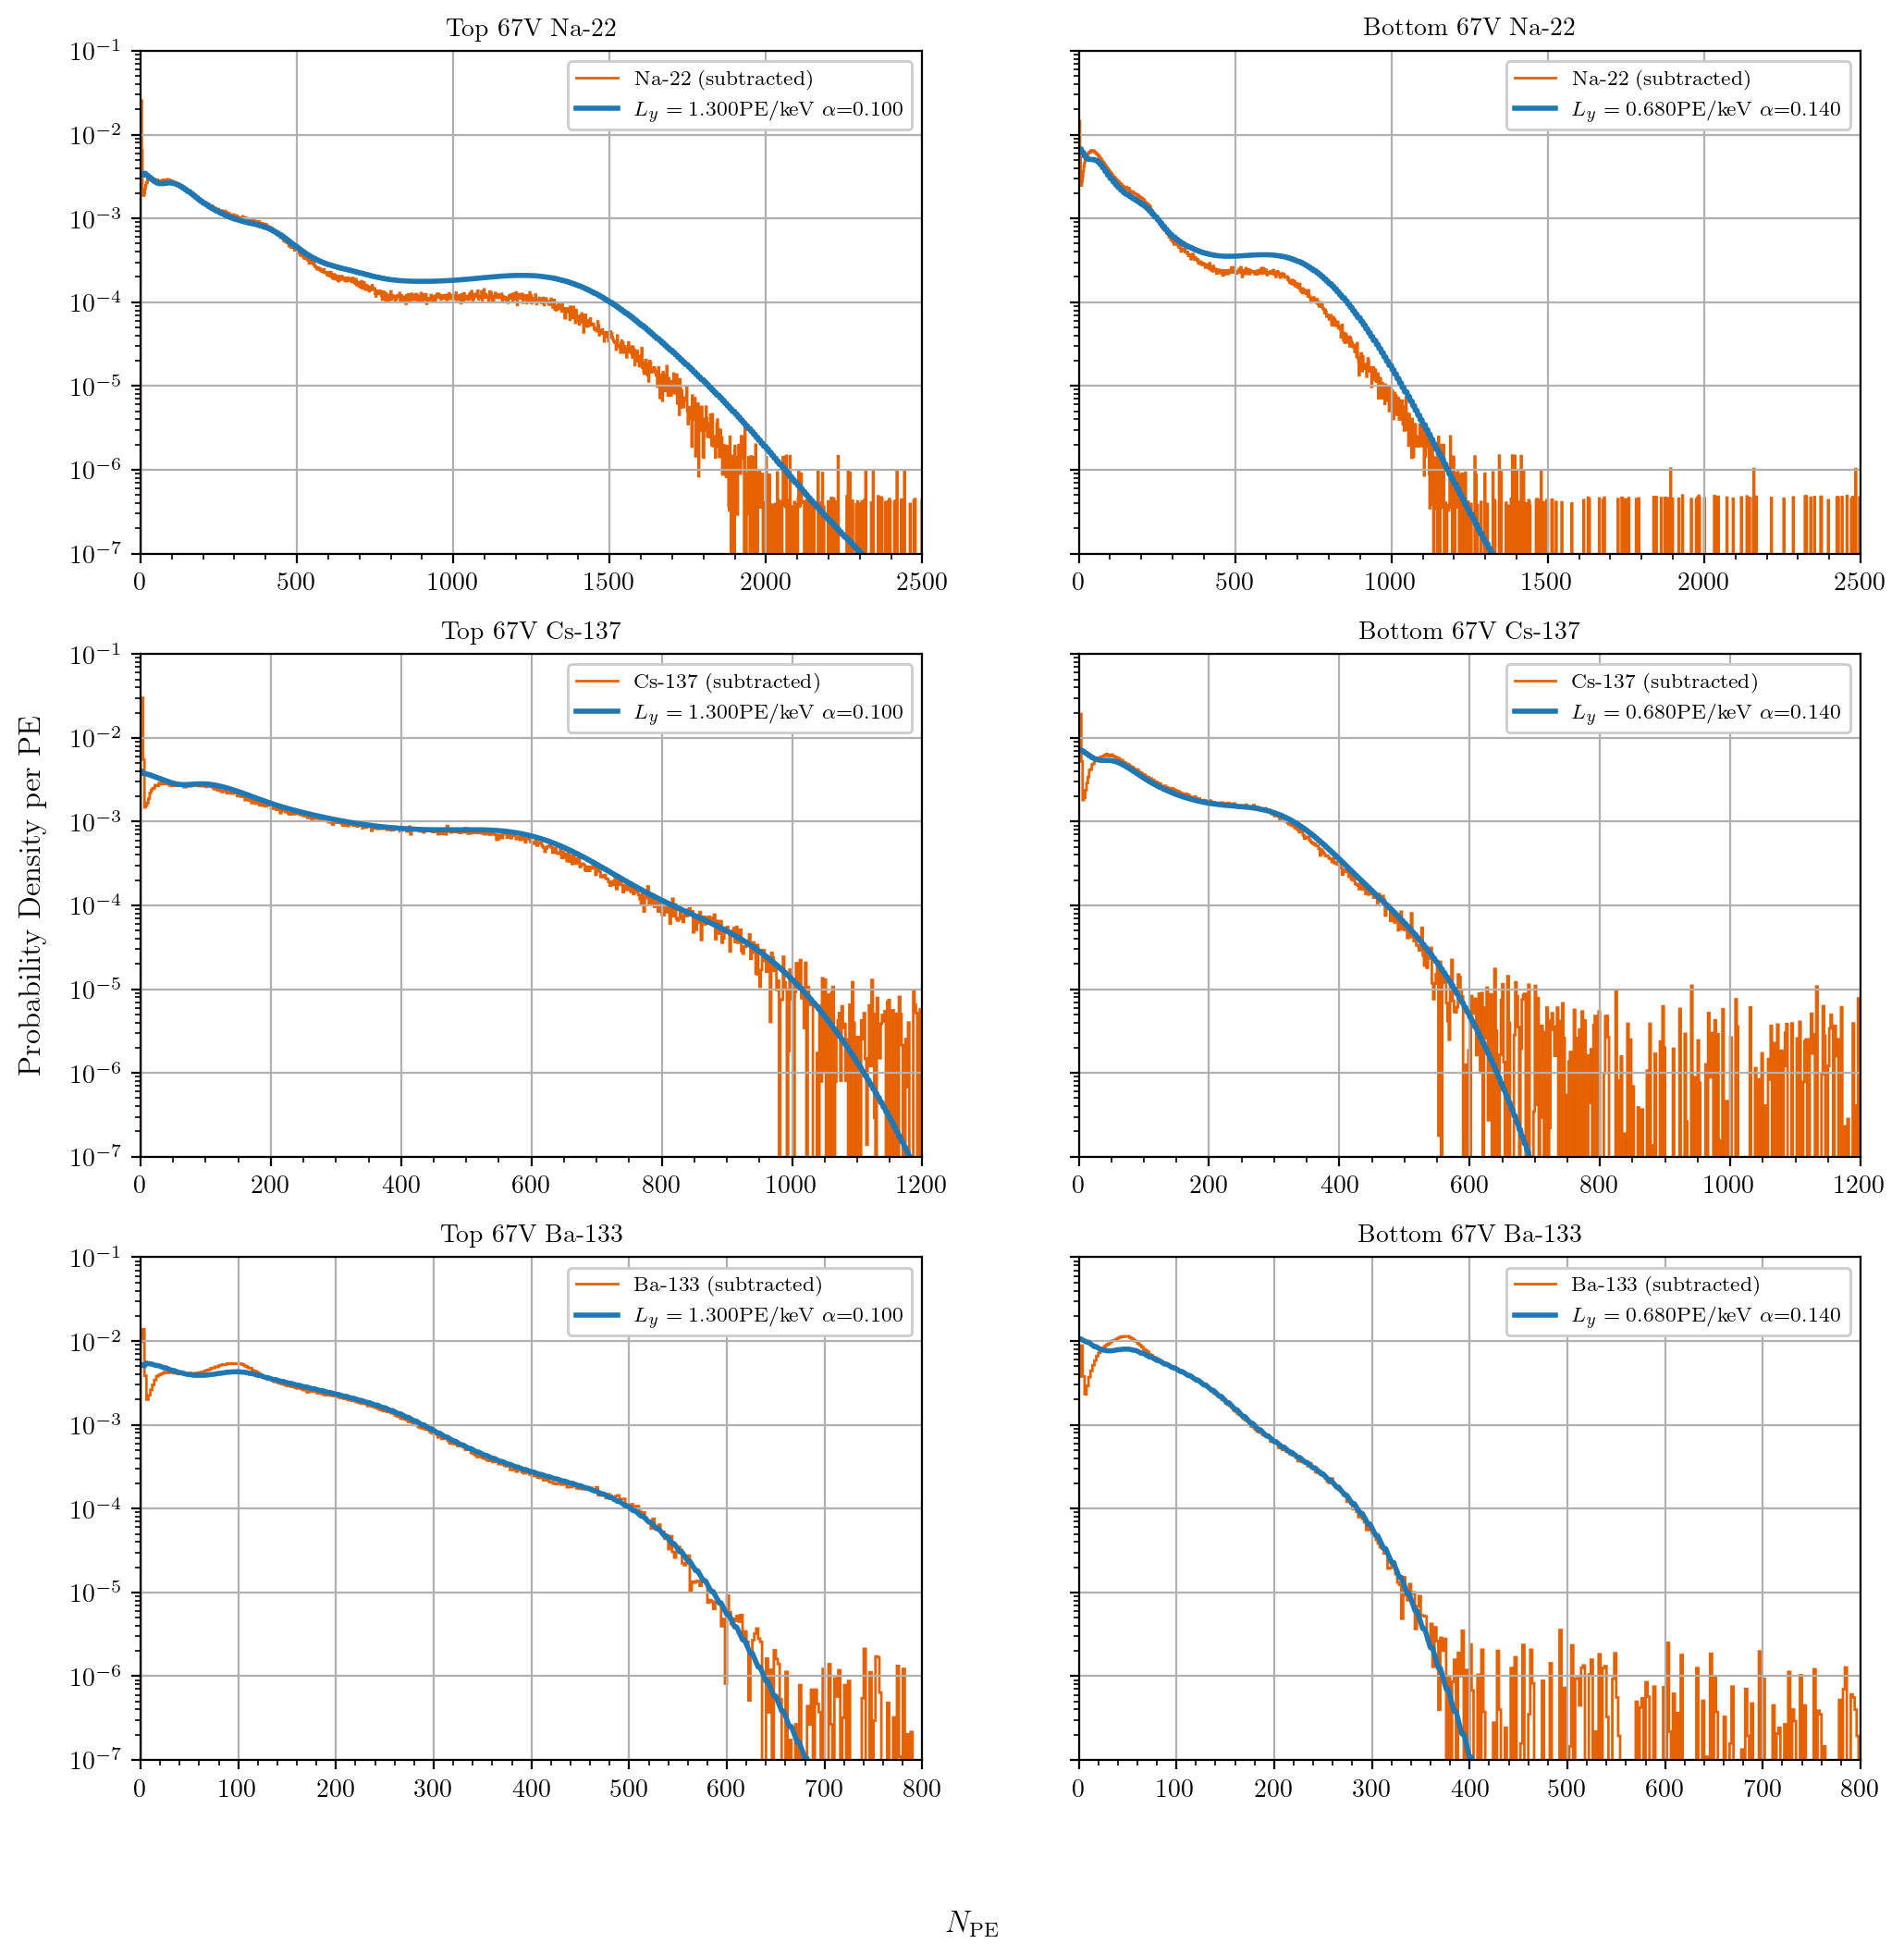

In [ ]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(3, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 12)
light_yield = {'top':1.3, 'bottom':0.68}
alpha = {'top':0.1, 'bottom':0.14}
max_pe = {'Na-22':2500, 'Cs-137':1200, 'Ba-133':800}
files = {'Na-22':'spectrum_na22_ene.root', 'Cs-137':'spectrum_cs137_ene.root', 'Ba-133':'spectrum_ba133_ene.root'}
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        for k, t in enumerate(types[-3:]):
            integral = np.sum(spectra[t][pos][volt]['counts'])
            bin_width = spectra[t][pos][volt]['bins'][1]-spectra[t][pos][volt]['bins'][0]
            axs[k, i].stairs(
                spectra[t][pos][volt]['counts']/integral/bin_width,
                spectra[t][pos][volt]['bins'],
                label=f'{t}', color=f'C1'
            )
            model = Spectrum(p_dict[pos][67], pe_max=max_pe[types[k+1]]*1.2, pe_width=max_pe[types[k+1]]/300, root_file_path=f"data/gamma/{files[types[k+1]]}")
            axs[k, i].plot(
                spectra[t][pos][volt]['bins'],
                model.pe_spectrum(spectra[t][pos][volt]['bins'], light_yield[pos], alpha[pos], 1), 
                label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(light_yield[pos], alpha[pos])
            )
            axs[k, i].legend(loc='upper right')
            axs[k, i].set_ylim(1e-7, 1e-1)
            axs[k, i].set_xlim(spectra[t][pos][volt]['bins'][0],max_pe[types[k+1]])
            axs[k, i].set_yscale('log')
            axs[k, i].minorticks_on()
            axs[k, i].grid()
            axs[k, i].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V {types[k+1]}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Probability Density per PE', x=0.07)

## Fit

In [ ]:
# Initialize container
spectrum_fit = {}
sources = ['Cs-137', 'Ba-133']
for pos in positions:
    spectrum_fit[pos] = {}
    for s in sources:
        spectrum_fit[pos][s] = {}

In [ ]:
ly_guess = {'top':[1.3,1.3], 'bottom':[0.62,0.62]}
fit_min = {'top':[200,200], 'bottom':[100,100]}
fit_max = {'top':[1000,600], 'bottom':[550,360]}
files = ['data/gamma/spectrum_cs137_ene.root','data/gamma/spectrum_ba133_ene.root']
analytic_spectra = {'top':[], 'bottom':[]}
volt = 67
for pos in positions:
    for i,s in enumerate(sources):
        print(f'Running for {pos} {s}')
        # Spectrum fit range
        spectrum_fit[pos][s]['fit_range'] = [fit_min[pos][i], fit_max[pos][i]]
        spectrum_fit[pos][s]['data'] = {
            'bins':spectra[s+' (subtracted)'][pos][volt]['bins'],
            'x':0.5*(spectra[s+' (subtracted)'][pos][volt]['bins'][1:]+spectra[s+' (subtracted)'][pos][volt]['bins'][:-1]), 
            'y':spectra[s+' (subtracted)'][pos][volt]['counts'], 
            'yerr':spectra[s+' (subtracted)'][pos][volt]['errs']
        }
        spec = Spectrum(dict=p_dict[pos][volt],pe_max=spectrum_fit[pos][s]['fit_range'][1]*1.5, pe_width=spectrum_fit[pos][s]['fit_range'][1]/500, root_file_path=files[i])
        analytic_spectra[pos].append(spec)
        in_fit_range = (spectrum_fit[pos][s]['data']['x']>spectrum_fit[pos][s]['fit_range'][0])&(spectrum_fit[pos][s]['data']['x']<spectrum_fit[pos][s]['fit_range'][1])
        spectrum_fit[pos][s]['pars'], spectrum_fit[pos][s]['cov'] = curve_fit(
            spec.pe_spectrum, 
            spectrum_fit[pos][s]['data']['x'][in_fit_range],
            spectrum_fit[pos][s]['data']['y'][in_fit_range],
            p0=[ly_guess[pos][i], 0.1, np.sum(spectrum_fit[pos][s]['data']['y'])],
            sigma=spectrum_fit[pos][s]['data']['yerr'][in_fit_range],
            maxfev=10000)
        # spectrum_fit[pos][s]['chi2'] = {'x': X, 'y':Y, 'z':chi2map}
        spectrum_fit[pos][s]['chi2'] = np.sum(((spectrum_fit[pos][s]['data']['y'][in_fit_range]-spec.pe_spectrum(spectrum_fit[pos][s]['data']['x'][in_fit_range],*spectrum_fit[pos][s]['pars'])) / spectrum_fit[pos][s]['data']['yerr'][in_fit_range]) ** 2)
        spectrum_fit[pos][s]['dof'] = np.sum(in_fit_range)-3
        print(f'chi2={spectrum_fit[pos][s]["chi2"]} dof={spectrum_fit[pos][s]["dof"]}')

        # Print best fit values and 68% CL
        ly_fit = spectrum_fit[pos][s]['pars'][0]
        alpha_fit = spectrum_fit[pos][s]['pars'][1]
        ly_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][0,0])
        alpha_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][1,1])
        print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
        spectrum_fit[pos][s]['ly'] = ly_fit
        spectrum_fit[pos][s]['ly_err'] = ly_68
        spectrum_fit[pos][s]['alpha'] = alpha_fit
        spectrum_fit[pos][s]['alpha_err'] = alpha_68

Running for top Cs-137


chi2=482.3915278700064 dof=397
Ly=1.264+/-0.004 PE/keV  alpha=0.115+/-0.005 (68% CL)
Running for top Ba-133
chi2=236.91962323496102 dof=197
Ly=1.314+/-0.004 PE/keV  alpha=0.084+/-0.004 (68% CL)
Running for bottom Cs-137
chi2=343.6060301777825 dof=222
Ly=0.645+/-0.003 PE/keV  alpha=0.168+/-0.006 (68% CL)
Running for bottom Ba-133
chi2=165.83683244479295 dof=127
Ly=0.668+/-0.004 PE/keV  alpha=0.143+/-0.007 (68% CL)


Text(0.02, 0.5, 'Rate [A.U.]')

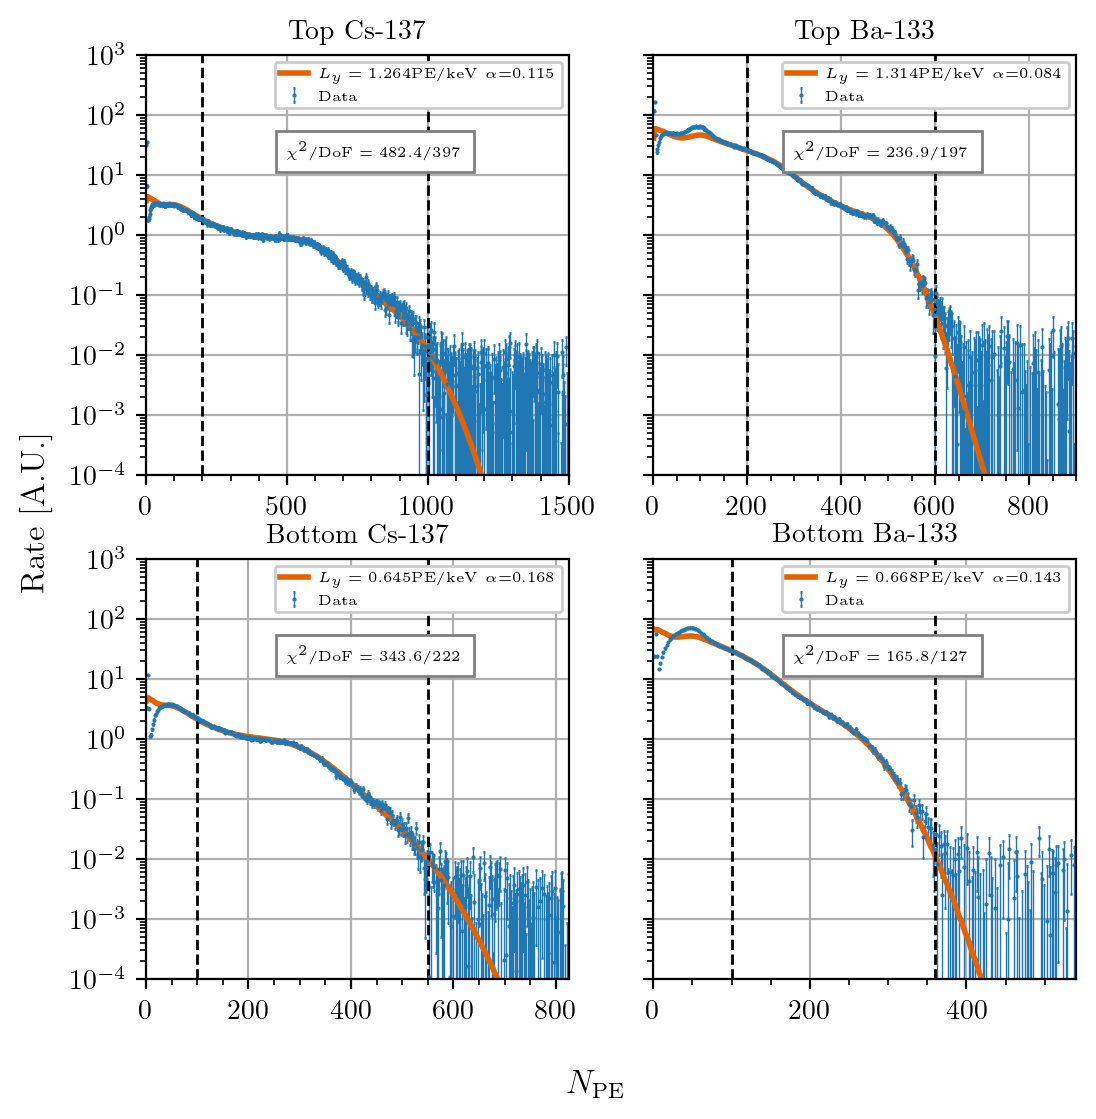

In [ ]:
# Make plots for all datasets
# Fitted spectra
fig, axs = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(6, 6)
ymin = 1e-4
ymax = 1e3
for i,pos in enumerate(positions):
    for j,s in enumerate(sources):
        axs[i,j].errorbar(
            spectrum_fit[pos][s]['data']['x'],
            spectrum_fit[pos][s]['data']['y'],
            yerr=spectrum_fit[pos][s]['data']['yerr'],
            fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5
        )
        axs[i,j].plot(
            spectrum_fit[pos][s]['data']['x'],
            analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 
            label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(spectrum_fit[pos][s]['ly'], spectrum_fit[pos][s]['alpha'])
        )
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][0]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][1]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].text(
            spectrum_fit[pos][s]['fit_range'][1]*0.5, 
            ymax/50, 
            r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(spectrum_fit[pos][s]['chi2'],spectrum_fit[pos][s]['dof']), 
            fontsize=5,bbox=dict(facecolor='white',edgecolor='grey',alpha=1)
        )
        axs[i,j].grid()
        axs[i,j].minorticks_on()
        axs[i,j].set_yscale('log')
        axs[i,j].legend(loc='upper right', fontsize=5)
        axs[i,j].set_xlim(0, spectrum_fit[pos][s]['fit_range'][1]*1.5)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} {s}')
fig.supxlabel(r'$N_{\rm PE}$')
fig.supylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

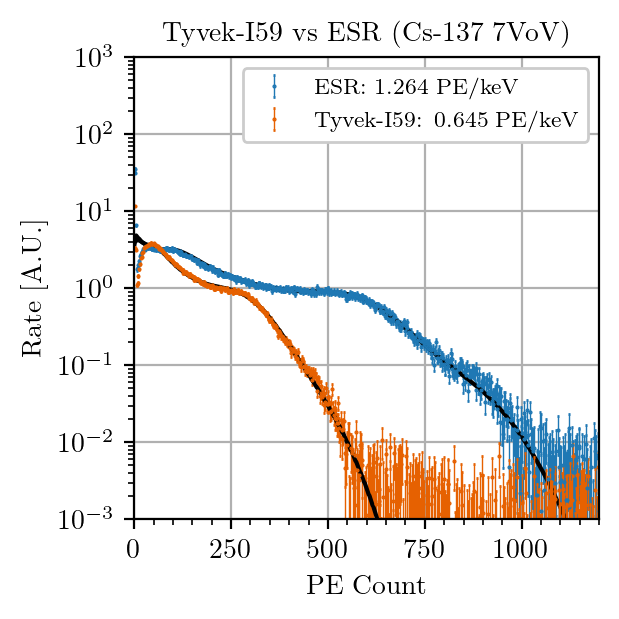

In [ ]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Cs-137'
j=0
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 1200)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Cs-137 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

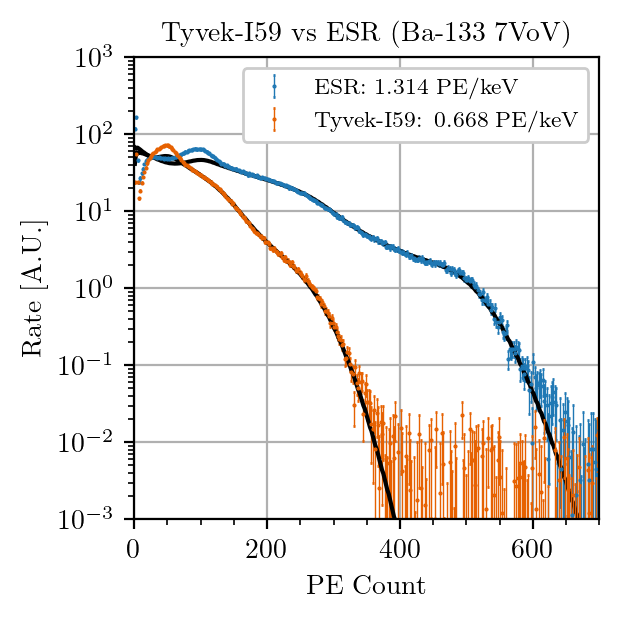

In [ ]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Ba-133'
j=1
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 700)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Ba-133 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

## Top-Bottom Comparison
The error bars for light yield (ratio) here include the contribution from calibration (SPE gain and DiCT probability)

In [ ]:
# Initialize container
results = {
    'ly':{
        'ESR':{},'Tyvek':{}
    }, 
    'alpha':{
        'ESR':{},'Tyvek':{}
    },
    'ly_ratio':{
        'theory':{}, 'experiment':{}    
    }
}

Average Tyvek-to-ESR Ly ratio = 0.5092+/-0.0108(stat)+/-0.0013(sys)


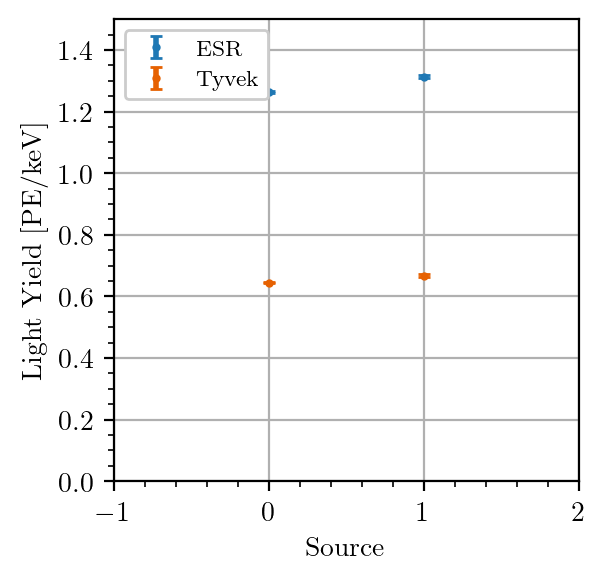

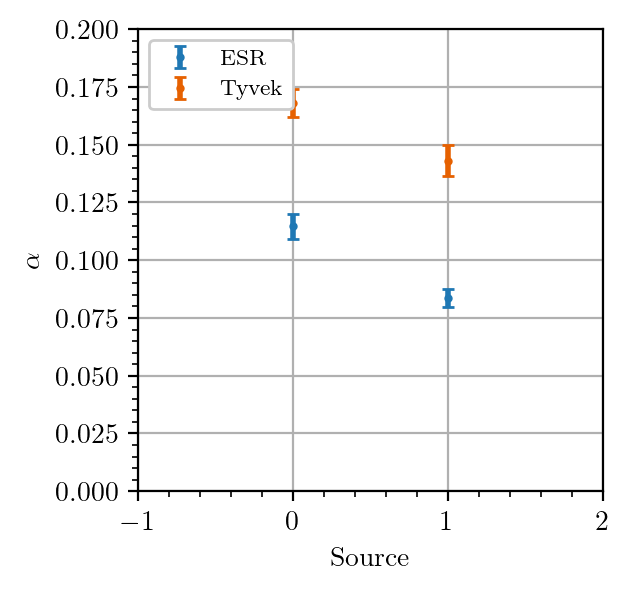

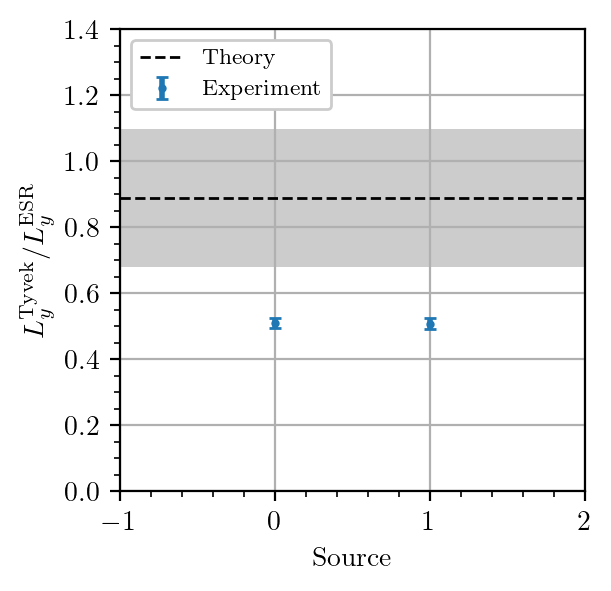

In [ ]:
ly_ratio_th = 0.890
ly_ratio_th_err = 0.209
volt=67

for k1 in list(results.keys()):
    for k2,pos in zip(list(results[k1].keys()),positions):
        if k1=='ly' or k1=='alpha':
            results[k1][k2]['x'] = np.array([0,1])
            results[k1][k2]['y'] = np.array([spectrum_fit[pos][s][k1] for s in sources])
            results[k1][k2]['yerr'] = np.array([spectrum_fit[pos][s][k1+'_err'] for s in sources])
        elif k1=='ly_ratio':
            if k2=='theory':
                results[k1][k2]['x'] = np.array([-1, 2])
                results[k1][k2]['y'] = np.array([ly_ratio_th]*2)
                results[k1][k2]['yerr'] = np.array([ly_ratio_th_err]*2)
            elif k2=='experiment':
                results[k1][k2]['x'] = np.array([0, 1])
                results[k1][k2]['y'] = np.array([spectrum_fit['bottom'][s]['ly']/spectrum_fit['top'][s]['ly'] for s in sources])
                results[k1][k2]['yerr'] = np.array([
                (  
                    (spectrum_fit['top'][s]['ly_err']/spectrum_fit['top'][s]['ly'])**2 + 
                    syserr2['top'][volt] + 
                    (spectrum_fit['bottom'][s]['ly_err']/spectrum_fit['bottom'][s]['ly'])**2 + 
                    syserr2['bottom'][volt]
                )**0.5 for s in sources
                ])

plt.figure(1,figsize=(3,3))
labels = {'top':'ESR','bottom':'Tyvek'}
for ref in list(results['ly'].keys()):   
    plt.errorbar(
        results['ly'][ref]['x'],
        results['ly'][ref]['y'],
        yerr=results['ly'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,1.5)

plt.figure(2,figsize=(3,3))
for ref in list(results['alpha'].keys()):   
    plt.errorbar(
        results['alpha'][ref]['x'],
        results['alpha'][ref]['y'],
        yerr=results['alpha'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,0.2)

plt.figure(3,figsize=(3,3))
plt.errorbar(
    results['ly_ratio']['experiment']['x'],
    results['ly_ratio']['experiment']['y'],
    yerr=results['ly_ratio']['experiment']['yerr'], 
    fmt='o', label='Experiment', ls='none', elinewidth=2, capsize=2, markersize=2
)
plt.fill_between(
    x=results['ly_ratio']['theory']['x'],
    y1=results['ly_ratio']['theory']['y']-results['ly_ratio']['theory']['yerr'], 
    y2=results['ly_ratio']['theory']['y']+results['ly_ratio']['theory']['yerr'],
    facecolor='k',alpha=0.2
)
plt.plot(
    results['ly_ratio']['theory']['x'], 
    results['ly_ratio']['theory']['y'], 
    'k--', label='Theory', linewidth=1
)
plt.xlabel('Source')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlim(-1,2)
plt.ylim(0,1.4)

# Weighted average and statistical uncertainty
lyr_mu = np.sum(results['ly_ratio']['experiment']['y']/results['ly_ratio']['experiment']['yerr']**2) \
    /np.sum(1/results['ly_ratio']['experiment']['yerr']**2)
lyr_sigma = 1/np.sqrt(np.sum(1/results['ly_ratio']['experiment']['yerr']**2))
# RMS variation -> "systematic" uncertainty
lyr_rms = np.std(results['ly_ratio']['experiment']['y'], ddof=1)
print(f'Average Tyvek-to-ESR Ly ratio = {lyr_mu:.4f}+/-{lyr_sigma:.4f}(stat)+/-{lyr_rms:.4f}(sys)')
